Connected to Python 3.9.10

In [1]:
curve_df = pd.read_pickle(OUTPUT_DIR+'/'+outfile+'_curve.pkl')

NameError: name 'pd' is not defined

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import ast
import re

In [3]:
sys.path.append('../../src/package')
sys.path.append('../../../BondsTable')
sys.path.append('../../tests')
sys.path.append('../../data')
import discfact as df
import pvfn as pv
import DateFunctions_1 as dates
import Curve_Plotting as cp
OUTPUT_DIR = 'C:/Users/zhang/OneDrive/Documents/GitHub/UST-yieldcurves_2024/curve_utils/output'

c:\Users\zhang\OneDrive\Documents\GitHub\UST-yieldcurves_2024\curve_utils\src\package\../development\crsp_data_processing.py:46: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  bonddata = pd.read_csv(filepath)
c:\Users\zhang\OneDrive\Documents\GitHub\UST-yieldcurves_2024\curve_utils\src\package\../development\crsp_data_processing.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonddata['Spread'] = bonddata['TMASK'] - bonddata['TMBID']
c:\Users\zhang\OneDrive\Documents\GitHub\UST-yieldcurves_2024\curve_utils\src\package\../development\crsp_data_processing.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [4]:
outfile = 'curve_test2000'
curve_df = pd.read_pickle(OUTPUT_DIR+'/'+outfile+'_curve.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/zhang/OneDrive/Documents/GitHub/UST-yieldcurves_2024/curve_utils/output/curve_test2000_curve.pkl'

In [5]:
outfile = 'test2000'
curve_df = pd.read_pickle(OUTPUT_DIR+'/'+outfile+'_curve.pkl')

In [6]:
curve_df

type  quotedate  \
type_ind quotedate_ind                    
pwcf     20000131       pwcf  [36555.0]   
         20000229       pwcf  [36584.0]   
pwlz     20000131       pwlz  [36555.0]   
         20000229       pwlz  [36584.0]   
pwtf     20000131       pwtf  [36555.0]   
         20000229       pwtf  [36584.0]   

                                                                   breaks  \
type_ind quotedate_ind                                                      
pwcf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwlz     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwtf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   

                                                                    rates  
type_ind quotedate_ind                                                     
pwcf     20000131       [0.03155834861641242, 0.01624840911648632, 0.1...  
         20000229       [0.04333817646520892, 0.06865186999190424, 0.0...  
pwlz     20000131       [0.08306564790634006, 0.016131279869252384, 0....  
         20000229       [0.10923360890959918, -0.0016923185531181129, ...  
pwtf     20000131       [0.055888072351500756, 0.095167363313876, 0.00...  
         20000229       [0.01800434919547239, 0.12044565495031759, -0....

In [7]:
def apply_parbond_rates_to_df(df, plot_points_yr, twostep=False):
    results = []
    for index, row in df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        parbond_rates_output = parbond_rates(curve, plot_points_yr, twostep)
        results.append([curve[0], curve[1]] + list(parbond_rates_output))  # Adjust as needed based on output structure
    columns = ['type', 'quotedate'] + [f'Year_{yr:.2f}' for yr in plot_points_yr]
    results_df = pd.DataFrame(results, columns=columns)
    return results_df

In [8]:
parbond_breaks = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])

In [9]:
def apply_parbond_rates_to_df(df, plot_points_yr, twostep=False):
    results = []
    for index, row in df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        parbond_rates_output = parbond_rates(curve, plot_points_yr, twostep)
        results.append([curve[0], curve[1]] + list(parbond_rates_output))  # Adjust as needed based on output structure
    columns = ['type', 'quotedate'] + [f'Year_{yr:.2f}' for yr in plot_points_yr]
    results_df = pd.DataFrame(results, columns=columns)
    return results_df

final_df = final_df = apply_parbond_rates_to_df(curve_df, parbond_breaks, twostep=True)

NameError: name 'parbond_rates' is not defined

In [10]:
def parbond_rates(curve,plot_points_yr,twostep=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + plot_points_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.bondYieldFromPrice_parms(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return(pbrates)

In [11]:
final_df = final_df = apply_parbond_rates_to_df(curve_df, parbond_breaks, twostep=True)

In [12]:
final_df

,type,quotedate,Year_0.08,Year_0.50,Year_1.00,Year_1.50,Year_2.00,Year_3.00,Year_4.00,Year_5.00,Year_7.00,Year_10.00,Year_15.00,Year_20.00
0,pwcf,[36555.0],0.030762,0.071055,0.059919,0.064970,0.067514,0.066100,0.065391,0.066509,0.067777,0.065314,0.061452,0.068704
1,pwcf,[36584.0],0.046416,0.059464,0.063735,0.064943,0.065544,0.066511,0.066992,0.066847,0.066682,0.066056,0.065302,0.064805
2,pwlz,[36555.0],0.082613,0.061094,0.063380,0.065033,0.066641,0.067125,0.067579,0.067794,0.068198,0.068455,0.068580,0.067087
3,pwlz,[36584.0],0.106748,0.064613,0.064126,0.064048,0.063972,0.065966,0.067912,0.067160,0.065630,0.064685,0.064304,0.066415
4,pwtf,[36555.0],0.060297,0.044257,0.066682,0.066416,0.065140,0.066372,0.067273,0.067709,0.068041,0.067300,0.066982,0.071502
5,pwtf,[36584.0],0.029164,0.041333,0.067820,0.065234,0.062848,0.066573,0.068378,0.065971,0.063701,0.068082,0.072090,0.067734


In [13]:
def apply_parbond_rates_to_df(df, plot_points_yr, twostep=False):
    results = []
    for index, row in df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        parbond_rates_output = parbond_rates(curve, plot_points_yr, twostep)
        results.append([curve[0], curve[1]] + list(parbond_rates_output))  # Adjust as needed based on output structure
    columns = ['type', 'quotedate'] + [f'Year{yr}' for yr in plot_points_yr]
    results_df = pd.DataFrame(results, columns=columns)
    return results_df

final_df = apply_parbond_rates_to_df(curve_df, parbond_breaks, twostep=True)

In [14]:
final_df

,type,quotedate,Year0.0833,Year0.5,Year1.0,Year1.5,Year2.0,Year3.0,Year4.0,Year5.0,Year7.0,Year10.0,Year15.0,Year20.0
0,pwcf,[36555.0],0.030762,0.071055,0.059919,0.064970,0.067514,0.066100,0.065391,0.066509,0.067777,0.065314,0.061452,0.068704
1,pwcf,[36584.0],0.046416,0.059464,0.063735,0.064943,0.065544,0.066511,0.066992,0.066847,0.066682,0.066056,0.065302,0.064805
2,pwlz,[36555.0],0.082613,0.061094,0.063380,0.065033,0.066641,0.067125,0.067579,0.067794,0.068198,0.068455,0.068580,0.067087
3,pwlz,[36584.0],0.106748,0.064613,0.064126,0.064048,0.063972,0.065966,0.067912,0.067160,0.065630,0.064685,0.064304,0.066415
4,pwtf,[36555.0],0.060297,0.044257,0.066682,0.066416,0.065140,0.066372,0.067273,0.067709,0.068041,0.067300,0.066982,0.071502
5,pwtf,[36584.0],0.029164,0.041333,0.067820,0.065234,0.062848,0.066573,0.068378,0.065971,0.063701,0.068082,0.072090,0.067734


In [15]:
def apply_parbond_rates_to_df(df, plot_points_yr, twostep=False):
    results = []
    for index, row in df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        parbond_rates_output = parbond_rates(curve, plot_points_yr, twostep)
        results.append([curve[0], curve[1]] + list(parbond_rates_output))  # Adjust as needed based on output structure
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in plot_points_yr]
    results_df = pd.DataFrame(results, columns=columns)
    return results_df

final_df = apply_parbond_rates_to_df(curve_df, parbond_breaks, twostep=True)

In [16]:
final_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.030762,0.071055,0.059919,0.064970,0.067514,0.066100,0.065391,0.066509,0.067777,0.065314,0.061452,0.068704
1,pwcf,[36584.0],0.046416,0.059464,0.063735,0.064943,0.065544,0.066511,0.066992,0.066847,0.066682,0.066056,0.065302,0.064805
2,pwlz,[36555.0],0.082613,0.061094,0.063380,0.065033,0.066641,0.067125,0.067579,0.067794,0.068198,0.068455,0.068580,0.067087
3,pwlz,[36584.0],0.106748,0.064613,0.064126,0.064048,0.063972,0.065966,0.067912,0.067160,0.065630,0.064685,0.064304,0.066415
4,pwtf,[36555.0],0.060297,0.044257,0.066682,0.066416,0.065140,0.066372,0.067273,0.067709,0.068041,0.067300,0.066982,0.071502
5,pwtf,[36584.0],0.029164,0.041333,0.067820,0.065234,0.062848,0.066573,0.068378,0.065971,0.063701,0.068082,0.072090,0.067734


In [17]:
def zerobond_rates(curve,plot_points_yr,twostep=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + plot_points_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    zbrates = pv.bondYieldFromPrice_parms(df_maturity, 
                            parms=parms_maturity, 
                            settledate=xquotedate, parmflag=True, padj=False)
    return zbrates

In [18]:
b = zerobond_rates(curvepwcf,plot_points_yr,twostep=False)

NameError: name 'curvepwcf' is not defined

In [19]:
quotedate=dates.YMDtoJulian(19321231)
breaks = np.array([0.0833, 0.5, 1.,2.,5.,10.,20.,30.])
breakdates = dates.CalAdd(quotedate,nyear=breaks)
plot_points_yr = np.arange(.01,30,.01)
#plot_points_yr = np.arange(.1,30,.1)

parbond_breaks = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
rates = np.array([0.02,.025,.03,.035,.04,.045,.05,.06] )
ratescc = 2.*np.log(1+rates/2.)
curvepwcf = ['pwcf',quotedate,breakdates,ratescc]
curvepwlz = ['pwlz',quotedate,breakdates,ratescc]
curvepwtf = ['pwtf',quotedate,breakdates,ratescc+0.005]

In [20]:
b = zerobond_rates(curvepwcf,plot_points_yr,twostep=False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [21]:
curve = curvepwcf

In [22]:
xquotedate = curve[1]
plot_points = np.round(xquotedate + plot_points_yr*365.25,0)

In [23]:
parms_maturity= []
parms_annuity = []
for i in plot_points:   # Make the dummy bonds for zero and annuity
    parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
    parms_maturity.append(parms_maturity_single)

parms_maturity = pd.DataFrame(parms_maturity)
df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]

In [24]:
df_maturity

array([99.97820836, 99.96186774, 99.94008441, ..., 22.62089054,
       22.60990928, 22.5952759 ])

In [25]:
parms_maturity

,0,1,2,3,4,5,6,7
0,0,12057.0,2,100.0,A/A,eomyes,0,False
1,0,12060.0,2,100.0,A/A,eomyes,0,False
2,0,12064.0,2,100.0,A/A,eomyes,0,False
3,0,12068.0,2,100.0,A/A,eomyes,0,False
4,0,12071.0,2,100.0,A/A,eomyes,0,False
...,...,...,...,...,...,...,...,...
2994,0,22992.0,2,100.0,A/A,eomyes,0,False
2995,0,22996.0,2,100.0,A/A,eomyes,0,False
2996,0,23000.0,2,100.0,A/A,eomyes,0,False
2997,0,23003.0,2,100.0,A/A,eomyes,0,False


In [26]:
zbrates = pv.bondYieldFromPrice_parms(df_maturity, 
                        parms=parms_maturity, parmflag=True, padj=False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [27]:
df_maturity

array([99.97820836, 99.96186774, 99.94008441, ..., 22.62089054,
       22.60990928, 22.5952759 ])

In [28]:
zbrates = df_maturity.copy()/100.

In [29]:
zbrates

array([0.99978208, 0.99961868, 0.99940084, ..., 0.22620891, 0.22609909,
       0.22595276])

In [30]:
zbrates = df_maturity.copy()/100.
zbrates = pv.bondYieldFromPrice_parms(df_maturity, parms=parms_maturity, parmflag=True, padj=False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [31]:
zbrates = df_maturity.copy()/100.

In [32]:
for j in range(len(zbrates)):
    zbrates[j] = pv.bondYieldFromPrice_parms(df_maturity[j], parms=parms_maturity[j:j], parmflag=True, padj=False)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [33]:
for j in range(len(zbrates)):
    zbrates[j] = pv.bondYieldFromPrice_parms(df_maturity[j], parms=parms_maturity.loc[j:j], parmflag=True, padj=False)

In [34]:
zbrates

array([6.60220446e-06, 1.15509979e-05, 1.81455796e-05, ...,
       2.37428575e-02, 2.37475442e-02, 2.37537913e-02])

In [35]:
xquotedate = curve[1]
plot_points = np.round(xquotedate + plot_points_yr*365.25,0)
parms_annuity = []
for i in plot_points:
    parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
    parms_annuity.append(parms_annuity_single)

parms_annuity = pd.DataFrame(parms_annuity)

In [36]:
xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)

In [37]:
xx

array([[1.07606070e-02, 4.99891042e-01],
       [1.88310778e-02, 4.99809339e-01],
       [2.95917264e-02, 4.99700422e-01],
       ...,
       [1.65017294e+01, 1.65292019e+01],
       [1.65036778e+01, 1.65229086e+01],
       [1.65062795e+01, 1.65145213e+01]])

In [38]:
pv_annuity = xx[:,1]
accrued_interest = xx[:,1]-xx[:,0]
# This calculates the coupon rate for a clean price of 100
# This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
# Otherwise, I think we should use "Coupon = Yield"
# The coupon calculated in this way will almost be the right coupon, but not quite
# We can do a quick fix by calculating the yield for this coupon, because
# this will be almost the coupon that makes yield = coupon

df_annuity = pv_annuity - accrued_interest

In [39]:
df_annuity

array([1.07606070e-02, 1.88310778e-02, 2.95917264e-02, ...,
       1.65017294e+01, 1.65036778e+01, 1.65062795e+01])

In [40]:
pv_annuity

array([ 0.49989104,  0.49980934,  0.49970042, ..., 16.52920193,
       16.52290858, 16.51452131])

In [41]:
xquotedate = curve[1]
plot_points = np.round(xquotedate + plot_points_yr*365.25,0)
parms_annuity = []
for i in plot_points:
    parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
    parms_annuity.append(parms_annuity_single)

parms_annuity = pd.DataFrame(parms_annuity)
xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
pv_annuity = xx[:,1]
# accrued_interest = xx[:,1]-xx[:,0]
# df_annuity = pv_annuity - accrued_interest

annuityrates = pv_annuity.copy()/100.

In [42]:
for j in range(len(annuityrates)):
    annuityrates[j] = pv.bondYieldFromPrice_parms(pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)

ValueError: f(a) and f(b) must have different signs

In [43]:
pv_annuity

array([ 0.49989104,  0.49980934,  0.49970042, ..., 16.52920193,
       16.52290858, 16.51452131])

In [44]:
annuityrates = pv_annuity.copy()/100.

In [45]:
for j in range(len(annuityrates)):
    annuityrates[j] = pv.bondYieldFromPrice_parms(pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)

ValueError: f(a) and f(b) must have different signs

In [46]:
np.rate(2, -1, 0.4998910, fv=0)

<ipython-input-46-f748689c009f>:1: DeprecationWarning: In accordance with NEP 32, the function rate was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  np.rate(2, -1, 0.4998910, fv=0)


RuntimeError: In accordance with NEP 32, the function rate was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial

In [47]:
import numpy_financial

In [48]:
np.rate(2, -1, 0.4998910, fv=0)

<ipython-input-48-f748689c009f>:1: DeprecationWarning: In accordance with NEP 32, the function rate was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  np.rate(2, -1, 0.4998910, fv=0)


RuntimeError: In accordance with NEP 32, the function rate was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial

In [49]:
numpy_financial.rate(2, -1, 0.4998910, fv=0)

1.732520630134232

In [50]:
xquotedate = curve[1]
plot_points = np.round(xquotedate + plot_points_yr*365.25,0)
parms_annuity = []
for i in plot_points:
    parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
    parms_annuity.append(parms_annuity_single)

parms_annuity = pd.DataFrame(parms_annuity)
xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
pv_annuity = xx[:,1]
# accrued_interest = xx[:,1]-xx[:,0]
# df_annuity = pv_annuity - accrued_interest

yield_rate = numpy_financial.rate(2, -1, 0.4998910, fv=0)
annuityrates = pv_annuity.copy()/100.
for j in range(len(annuityrates)):
    annuityrates[j] = pv.bondYieldFromPrice_callable(pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)

In [51]:
annuityrates

array([32.08716996, 20.91814088, 14.90634361, ...,  0.05905382,
        0.05904747,  0.05903902])

In [52]:
xquotedate = curve[1]
plot_points = np.round(xquotedate + plot_points_yr*365.25,0)
parms_maturity= []
parms_annuity = []
for i in plot_points:   # Make the dummy bonds for zero and annuity
    parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
    parms_maturity.append(parms_maturity_single)

parms_maturity = pd.DataFrame(parms_maturity)
df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
zbrates = df_maturity.copy()/100.
for j in range(len(zbrates)):
    zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j], parmflag=True, padj=False)

In [53]:
zbrates

array([6.60220438e-06, 1.15509979e-05, 1.81455796e-05, ...,
       2.37428575e-02, 2.37475442e-02, 2.37537913e-02])

In [54]:
xquotedate = curve[1]
plot_points = np.round(xquotedate + plot_points_yr*365.25,0)
parms_maturity= []
parms_annuity = []
for i in plot_points:   # Make the dummy bonds for zero and annuity
    parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
    parms_maturity.append(parms_maturity_single)

parms_maturity = pd.DataFrame(parms_maturity)
df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
zbrates = df_maturity.copy()/100.
for j in range(len(zbrates)):
    zbrates[j] = pv.bondYieldFromPrice_parms(df_maturity[j], parms=parms_maturity.loc[j:j], parmflag=True, padj=False)

In [55]:
zbrates

array([6.60220446e-06, 1.15509979e-05, 1.81455796e-05, ...,
       2.37428575e-02, 2.37475442e-02, 2.37537913e-02])

In [56]:
xquotedate = curve[1]
plot_points = np.round(xquotedate + plot_points_yr*365.25,0)
parms_annuity = []
for i in plot_points:
    parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
    parms_annuity.append(parms_annuity_single)

parms_annuity = pd.DataFrame(parms_annuity)
xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
pv_annuity = xx[:,1]

In [57]:
xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
pv_annuity = xx[:,0]

In [58]:
annuityrates = pv_annuity.copy()/100.
for j in range(len(annuityrates)):
    annuityrates[j] = pv.bondYieldFromPrice_callable(
        pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)

In [59]:
annuityrates

array([2.60664386e+76, 2.84870047e+37, 4.84501910e+20, ...,
       5.91626190e-02, 5.91235796e-02, 5.90716051e-02])

In [60]:
pv_annuity

array([1.07606070e-02, 1.88310778e-02, 2.95917264e-02, ...,
       1.65017294e+01, 1.65036778e+01, 1.65062795e+01])

In [61]:
pv_annuity = xx[:,1]

In [62]:
pv_annuity

array([ 0.49989104,  0.49980934,  0.49970042, ..., 16.52920193,
       16.52290858, 16.51452131])

In [63]:
pv_annuity = xx[:,1]
# accrued_interest = xx[:,1]-xx[:,0]
# df_annuity = pv_annuity - accrued_interest

annuityrates = pv_annuity.copy()/100.
for j in range(len(annuityrates)):
    annuityrates[j] = pv.bondYieldFromPrice_callable(
        pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)

In [64]:
def parbond_rates(curve, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + parbd_breaks_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.bondYieldFromPrice_parms(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return(pbrates)

def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    zbrates = df_maturity.copy()/100.
    for j in range(len(zbrates)):
        zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j], parmflag=True, padj=False)
    return zbrates

def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates

In [65]:
parbd_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
zerobd_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
annuity_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])

In [66]:
def parbond_rates(curve, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + parbd_breaks_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.bondYieldFromPrice_parms(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return(pbrates)

def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    zbrates = df_maturity.copy()/100.
    for j in range(len(zbrates)):
        zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j], parmflag=True, padj=False)
    return zbrates

def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates

In [67]:
def produce_parbond_df(curve_df, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        parbond_rates = parbond_rates(curve, parbd_breaks_yr, twostep)
        results.append([curve[0], curve[1]] + list(parbond_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    parbond_df = pd.DataFrame(results, columns=columns)
    return parbond_df

In [68]:
parbond_df = produce_parbond_df(curve_df, parbd_breaks_yr, twostep=True)

UnboundLocalError: local variable 'parbond_rates' referenced before assignment

In [69]:
def produce_parbond_df(curve_df, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep)
        results.append([curve[0], curve[1]] + list(pb_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    pb_df = pd.DataFrame(results, columns=columns)
    return parbond_df

parbond_df = produce_parbond_df(curve_df, parbd_breaks_yr, twostep=True)

NameError: name 'parbond_df' is not defined

In [70]:
curve_df = pd.read_pickle(OUTPUT_DIR+'/'+outfile+'_curve.pkl')

In [71]:
def parbond_rates(curve, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + parbd_breaks_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.bondYieldFromPrice_parms(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return(pbrates)

def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    zbrates = df_maturity.copy()/100.
    for j in range(len(zbrates)):
        zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j], parmflag=True, padj=False)
    return zbrates

def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates

In [72]:
def produce_parbond_df(curve_df, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
        results.append([curve[0], curve[1]] + list(pb_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    pb_df = pd.DataFrame(results, columns=columns)
    return parbond_df

In [73]:
parbond_df = produce_parbond_df(curve_df, parbd_breaks_yr, twostep=True)

NameError: name 'parbond_df' is not defined

In [74]:
def produce_parbond_df(curve_df, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
        results.append([curve[0], curve[1]] + list(pb_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    pb_df = pd.DataFrame(results, columns=columns)
    return pd_df

parbond_df = produce_parbond_df(curve_df, parbd_breaks_yr, twostep=True)

NameError: name 'pd_df' is not defined

In [75]:
def produce_parbond_df(curve_df, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
        results.append([curve[0], curve[1]] + list(pb_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    pb_df = pd.DataFrame(results, columns=columns)
    return pb_df

parbond_df = produce_parbond_df(curve_df, parbd_breaks_yr, twostep=True)

In [76]:
parbond_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.030762,0.071055,0.059919,0.064970,0.067514,0.066100,0.065391,0.066509,0.067777,0.065314,0.061452,0.068704
1,pwcf,[36584.0],0.046416,0.059464,0.063735,0.064943,0.065544,0.066511,0.066992,0.066847,0.066682,0.066056,0.065302,0.064805
2,pwlz,[36555.0],0.082613,0.061094,0.063380,0.065033,0.066641,0.067125,0.067579,0.067794,0.068198,0.068455,0.068580,0.067087
3,pwlz,[36584.0],0.106748,0.064613,0.064126,0.064048,0.063972,0.065966,0.067912,0.067160,0.065630,0.064685,0.064304,0.066415
4,pwtf,[36555.0],0.060297,0.044257,0.066682,0.066416,0.065140,0.066372,0.067273,0.067709,0.068041,0.067300,0.066982,0.071502
5,pwtf,[36584.0],0.029164,0.041333,0.067820,0.065234,0.062848,0.066573,0.068378,0.065971,0.063701,0.068082,0.072090,0.067734


In [77]:
def produce_zerobond_df(curve_df, zerobd_breaks_yr, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        zerobond_rates = zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False)
        results.append([curve[0], curve[1]] + list(zerobond_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in zerobd_breaks_yr]
    zerobond_df = pd.DataFrame(results, columns=columns)
    return zerobond_df

In [78]:
def produce_zerobond_df(curve_df, zerobd_breaks_yr, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        zerobond_rates = zerobond_rates(curve, zerobd_breaks_yr, parmflag, padj)
        results.append([curve[0], curve[1]] + list(zerobond_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in zerobd_breaks_yr]
    zerobond_df = pd.DataFrame(results, columns=columns)
    return zerobond_df

parbond_df = produce_zerobond_df(curve_df, zerobd_breaks_yr, parmflag=True, padj=False)

UnboundLocalError: local variable 'zerobond_rates' referenced before assignment

In [79]:
def produce_zerobond_df(curve_df, zerobd_breaks_yr, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        zb_rates = zerobond_rates(curve, zerobd_breaks_yr, parmflag, padj)
        results.append([curve[0], curve[1]] + list(zb_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in zerobd_breaks_yr]
    zb_df = pd.DataFrame(results, columns=columns)
    return zb_df

parbond_df = produce_zerobond_df(curve_df, zerobd_breaks_yr, parmflag=True, padj=False)

In [80]:
parbond_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.000025,0.000348,0.000582,0.000945,0.001305,0.001894,0.002472,0.003120,0.004383,0.005795,0.007671,0.012070
1,pwcf,[36584.0],0.000038,0.000292,0.000621,0.000945,0.001264,0.001908,0.002538,0.003133,0.004292,0.005893,0.008333,0.010534
2,pwlz,[36555.0],0.000066,0.000300,0.000617,0.000947,0.001288,0.001927,0.002562,0.003182,0.004401,0.006142,0.008833,0.010844
3,pwlz,[36584.0],0.000085,0.000317,0.000624,0.000931,0.001232,0.001892,0.002578,0.003149,0.004211,0.005756,0.008211,0.011141
4,pwtf,[36555.0],0.000049,0.000218,0.000652,0.000969,0.001259,0.001906,0.002553,0.003182,0.004394,0.006016,0.008587,0.012360
5,pwtf,[36584.0],0.000024,0.000204,0.000663,0.000951,0.001212,0.001914,0.002599,0.003087,0.004075,0.006191,0.009596,0.010814


In [81]:
zerobond_df = produce_zerobond_df(curve_df, zerobd_breaks_yr, parmflag=True, padj=False)

In [82]:
zerobond_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.000025,0.000348,0.000582,0.000945,0.001305,0.001894,0.002472,0.003120,0.004383,0.005795,0.007671,0.012070
1,pwcf,[36584.0],0.000038,0.000292,0.000621,0.000945,0.001264,0.001908,0.002538,0.003133,0.004292,0.005893,0.008333,0.010534
2,pwlz,[36555.0],0.000066,0.000300,0.000617,0.000947,0.001288,0.001927,0.002562,0.003182,0.004401,0.006142,0.008833,0.010844
3,pwlz,[36584.0],0.000085,0.000317,0.000624,0.000931,0.001232,0.001892,0.002578,0.003149,0.004211,0.005756,0.008211,0.011141
4,pwtf,[36555.0],0.000049,0.000218,0.000652,0.000969,0.001259,0.001906,0.002553,0.003182,0.004394,0.006016,0.008587,0.012360
5,pwtf,[36584.0],0.000024,0.000204,0.000663,0.000951,0.001212,0.001914,0.002599,0.003087,0.004075,0.006191,0.009596,0.010814


In [83]:
def produce_annuity_df(curve_df, annuity_breaks_yr, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        anty_rates = annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False)
        results.append([curve[0], curve[1]] + list(anty_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in annuity_breaks_yr]
    anty_df = pd.DataFrame(results, columns=columns)
    return anty_df

In [84]:
def produce_annuity_df(curve_df, annuity_breaks_yr, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        anty_rates = annuity_rates(curve, annuity_breaks_yr, parmflag, padj)
        results.append([curve[0], curve[1]] + list(anty_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in annuity_breaks_yr]
    anty_df = pd.DataFrame(results, columns=columns)
    return anty_df

In [85]:
anty_df = produce_annuity_df(curve_df, annuity_breaks_yr, parmflag=True, padj=False)

In [86]:
anty_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],4.344500,1.690187,1.792394,0.665001,0.694820,0.440326,0.327363,0.264192,0.195824,0.147121,0.109716,0.093387
1,pwcf,[36584.0],3.304015,4.637202,1.538979,0.915885,0.654895,0.349913,0.318895,0.258690,0.175668,0.145184,0.104144,0.093205
2,pwlz,[36555.0],4.377953,1.683928,1.790086,0.664771,0.694161,0.440378,0.328039,0.264992,0.196447,0.148040,0.112649,0.095952
3,pwlz,[36584.0],3.327262,4.659276,1.542068,0.916466,0.654583,0.349602,0.318825,0.258764,0.175535,0.144546,0.103477,0.092944
4,pwtf,[36555.0],4.363618,1.672856,1.783982,0.664180,0.693013,0.439536,0.327467,0.264622,0.196227,0.147661,0.111807,0.096295
5,pwtf,[36584.0],3.297278,4.560088,1.533802,0.914218,0.653042,0.349283,0.318767,0.258503,0.174896,0.144502,0.106036,0.096263


No kernel connected

Connected to Python 3.9.10

In [1]:
import sys
import os
import numpy as np
import numpy_financial
import pandas as pd
import matplotlib.pyplot as plt
import time
import ast
import re

In [2]:
import sys
import os
import numpy as np
import numpy_financial
import pandas as pd
import matplotlib.pyplot as plt
import time
import ast
import re

In [3]:
sys.path.append('../../src/package')
sys.path.append('../../../BondsTable')
sys.path.append('../../tests')
sys.path.append('../../data')
import discfact as df
import pvfn as pv
import DateFunctions_1 as dates
import Curve_Plotting as cp

c:\Users\zhang\OneDrive\Documents\GitHub\UST-yieldcurves_2024\curve_utils\src\package\../development\crsp_data_processing.py:46: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  bonddata = pd.read_csv(filepath)
c:\Users\zhang\OneDrive\Documents\GitHub\UST-yieldcurves_2024\curve_utils\src\package\../development\crsp_data_processing.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonddata['Spread'] = bonddata['TMASK'] - bonddata['TMBID']
c:\Users\zhang\OneDrive\Documents\GitHub\UST-yieldcurves_2024\curve_utils\src\package\../development\crsp_data_processing.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [4]:
OUTPUT_DIR = '../../output'

In [5]:
import sys
import os
import numpy as np
import numpy_financial
import pandas as pd
import matplotlib.pyplot as plt
import time
import ast
import re
#%%

sys.path.append('../../src/package')
sys.path.append('../../../BondsTable')
sys.path.append('../../tests')
sys.path.append('../../data')
import discfact as df
import pvfn as pv
import DateFunctions_1 as dates
import Curve_Plotting as cp

In [6]:
OUTPUT_DIR = '../../output'

In [7]:
def parbond_rates(curve, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + parbd_breaks_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.bondYieldFromPrice_parms(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return(pbrates)

def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    zbrates = df_maturity.copy()/100.
    for j in range(len(zbrates)):
        zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j], parmflag=True, padj=False)
    return zbrates

def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates

In [8]:
def produce_parbond_df(curve_df, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
        results.append([curve[0], curve[1]] + list(pb_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    pb_df = pd.DataFrame(results, columns=columns)
    return pb_df

In [9]:
parbd_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
zerobd_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
annuity_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])

In [10]:
outfile = 'test2000'
curve_df = pd.read_pickle(OUTPUT_DIR+'/'+outfile+'_curve.pkl')

In [11]:
curve_df

type  quotedate  \
type_ind quotedate_ind                    
pwcf     20000131       pwcf  [36555.0]   
         20000229       pwcf  [36584.0]   
pwlz     20000131       pwlz  [36555.0]   
         20000229       pwlz  [36584.0]   
pwtf     20000131       pwtf  [36555.0]   
         20000229       pwtf  [36584.0]   

                                                                   breaks  \
type_ind quotedate_ind                                                      
pwcf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwlz     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwtf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   

                                                                    rates  
type_ind quotedate_ind                                                     
pwcf     20000131       [0.03155834861641242, 0.01624840911648632, 0.1...  
         20000229       [0.04333817646520892, 0.06865186999190424, 0.0...  
pwlz     20000131       [0.08306564790634006, 0.016131279869252384, 0....  
         20000229       [0.10923360890959918, -0.0016923185531181129, ...  
pwtf     20000131       [0.055888072351500756, 0.095167363313876, 0.00...  
         20000229       [0.01800434919547239, 0.12044565495031759, -0....

In [12]:
parbond_df = produce_parbond_df(curve_df, parbd_breaks_yr, twostep=True)

In [13]:
parbond_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.030762,0.071055,0.059919,0.064970,0.067514,0.066100,0.065391,0.066509,0.067777,0.065314,0.061452,0.068704
1,pwcf,[36584.0],0.046416,0.059464,0.063735,0.064943,0.065544,0.066511,0.066992,0.066847,0.066682,0.066056,0.065302,0.064805
2,pwlz,[36555.0],0.082613,0.061094,0.063380,0.065033,0.066641,0.067125,0.067579,0.067794,0.068198,0.068455,0.068580,0.067087
3,pwlz,[36584.0],0.106748,0.064613,0.064126,0.064048,0.063972,0.065966,0.067912,0.067160,0.065630,0.064685,0.064304,0.066415
4,pwtf,[36555.0],0.060297,0.044257,0.066682,0.066416,0.065140,0.066372,0.067273,0.067709,0.068041,0.067300,0.066982,0.071502
5,pwtf,[36584.0],0.029164,0.041333,0.067820,0.065234,0.062848,0.066573,0.068378,0.065971,0.063701,0.068082,0.072090,0.067734


In [14]:
def parbond_rates(curve, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + parbd_breaks_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.pv.bondYieldFromPrice_callable(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return(pbrates)

In [15]:
def parbond_rates(curve, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + parbd_breaks_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.pv.bondYieldFromPrice_callable(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return(pbrates)

In [16]:
def produce_parbond_df(curve_df, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
        results.append([curve[0], curve[1]] + list(pb_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    pb_df = pd.DataFrame(results, columns=columns)
    return pb_df

In [17]:
parbond_df = produce_parbond_df(curve_df, parbd_breaks_yr, twostep=True)

AttributeError: module 'pvfn' has no attribute 'pv'

In [18]:
def parbond_rates(curve, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + parbd_breaks_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.bondYieldFromPrice_callable(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return(pbrates)

def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    zbrates = df_maturity.copy()/100.
    for j in range(len(zbrates)):
        zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j], parmflag=True, padj=False)
    return zbrates

def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates
#################################################################################

def produce_parbond_df(curve_df, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
        results.append([curve[0], curve[1]] + list(pb_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    pb_df = pd.DataFrame(results, columns=columns)
    return pb_df

def produce_zerobond_df(curve_df, zerobd_breaks_yr, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        zb_rates = zerobond_rates(curve, zerobd_breaks_yr, parmflag, padj)
        results.append([curve[0], curve[1]] + list(zb_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in zerobd_breaks_yr]
    zb_df = pd.DataFrame(results, columns=columns)
    return zb_df

def produce_annuity_df(curve_df, annuity_breaks_yr, parmflag=True, padj=False):
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        anty_rates = annuity_rates(curve, annuity_breaks_yr, parmflag, padj)
        results.append([curve[0], curve[1]] + list(anty_rates))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in annuity_breaks_yr]
    anty_df = pd.DataFrame(results, columns=columns)
    return anty_df

In [19]:
parbond_df = produce_parbond_df(curve_df, parbd_breaks_yr, twostep=True)

In [20]:
parbond_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.030762,0.071055,0.059919,0.064970,0.067514,0.066100,0.065391,0.066509,0.067777,0.065314,0.061452,0.068704
1,pwcf,[36584.0],0.046416,0.059464,0.063735,0.064943,0.065544,0.066511,0.066992,0.066847,0.066682,0.066056,0.065302,0.064805
2,pwlz,[36555.0],0.082613,0.061094,0.063380,0.065033,0.066641,0.067125,0.067579,0.067794,0.068198,0.068455,0.068580,0.067087
3,pwlz,[36584.0],0.106748,0.064613,0.064126,0.064048,0.063972,0.065966,0.067912,0.067160,0.065630,0.064685,0.064304,0.066415
4,pwtf,[36555.0],0.060297,0.044257,0.066682,0.066416,0.065140,0.066372,0.067273,0.067709,0.068041,0.067300,0.066982,0.071502
5,pwtf,[36584.0],0.029164,0.041333,0.067820,0.065234,0.062848,0.066573,0.068378,0.065971,0.063701,0.068082,0.072090,0.067734


In [21]:
def calculate_rates(curve, breaks_yr, rate_type, twostep=False, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + breaks_yr * 365.25, 0)
    results = []

    if rate_type == 'parbond':
        parms_maturity = []
        parms_annuity = []
        for i in plot_points:
            parms_maturity_single = [0, i, 2, 100., "A/A", "eomyes", 0, False]
            parms_maturity.append(parms_maturity_single)
            parms_annuity_single = [1., i, 2, 0., "A/A", "eomyes", 0, False]
            parms_annuity.append(parms_annuity_single)
        parms_maturity = pd.DataFrame(parms_maturity)
        parms_annuity = pd.DataFrame(parms_annuity)
        parms_pb = parms_maturity.copy()

        df_maturity = pv.pvBondFromCurve(curve, settledate=xquotedate, parms=parms_maturity)[:, 1]
        xx = pv.pvBondFromCurve(curve, settledate=xquotedate, parms=parms_annuity)
        pv_annuity = xx[:, 1]
        accrued_interest = xx[:, 1] - xx[:, 0]
        coupon_rates = (100 - df_maturity) / (pv_annuity - accrued_interest)
        parms_pb[0] = coupon_rates
        dirtyprice = coupon_rates * pv_annuity + df_maturity
        pbrates = coupon_rates.copy() / 100.

        if twostep:
            for j in range(len(pbrates)):
                pbrates[j] = pv.bondYieldFromPrice_callable(dirtyprice[j], parms=parms_pb.loc[j:j],
                                                             settledate=xquotedate, parmflag=True, padj=False)
        results = pbrates

    elif rate_type == 'zerobond':
        parms_maturity = []
        for i in plot_points:
            parms_maturity_single = [0, i, 2, 100., "A/A", "eomyes", 0, False]
            parms_maturity.append(parms_maturity_single)
        parms_maturity = pd.DataFrame(parms_maturity)
        df_maturity = pv.pvBondFromCurve(curve, settledate=xquotedate, parms=parms_maturity)[:, 1]
        zbrates = df_maturity.copy() / 100.
        for j in range(len(zbrates)):
            zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j],
                                                         parmflag=True, padj=False)
        results = zbrates

    elif rate_type == 'annuity':
        parms_annuity = []
        for i in plot_points:
            parms_annuity_single = [1., i, 2, 0., "A/A", "eomyes", 0, False]
            parms_annuity.append(parms_annuity_single)
        parms_annuity = pd.DataFrame(parms_annuity)
        xx = pv.pvBondFromCurve(curve, settledate=xquotedate, parms=parms_annuity)
        pv_annuity = xx[:, 1]
        annuityrates = pv_annuity.copy() / 100.
        for j in range(len(annuityrates)):
            annuityrates[j] = pv.bondYieldFromPrice_callable(pv_annuity[j], parms=parms_annuity.loc[j:j],
                                                              parmflag=True, padj=False)
        results = annuityrates

    return results


def produce_rate_dfs(curve_df, parbd_breaks_yr, zerobd_breaks_yr, annuity_breaks_yr, twostep=False, parmflag=True, padj=False):
    parbond_results = []
    zerobond_results = []
    annuity_results = []

    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates = calculate_rates(curve, parbd_breaks_yr, 'parbond', twostep, parmflag, padj)
        zb_rates = calculate_rates(curve, zerobd_breaks_yr, 'zerobond', parmflag=parmflag, padj=padj)
        anty_rates = calculate_rates(curve, annuity_breaks_yr, 'annuity', parmflag=parmflag, padj=padj)

        parbond_results.append([curve[0], curve[1]] + list(pb_rates))
        zerobond_results.append([curve[0], curve[1]] + list(zb_rates))
        annuity_results.append([curve[0], curve[1]] + list(anty_rates))

    parbond_columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    zerobond_columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in zerobd_breaks_yr]
    annuity_columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in annuity_breaks_yr]

    pb_df = pd.DataFrame(parbond_results, columns=parbond_columns)
    zb_df = pd.DataFrame(zerobond_results, columns=zerobond_columns)
    anty_df = pd.DataFrame(annuity_results, columns=annuity_columns)

    return pb_df, zb_df, anty_df

# Example usage
outfile = 'test2000'
curve_df = pd.read_pickle(OUTPUT_DIR + '/' + outfile + '_curve.pkl')
parbd_breaks_yr = [1, 2, 5, 10, 20, 30]  # Example break points for par bond rates
zerobd_breaks_yr = [1, 2, 5, 10, 20, 30]  # Example break points for zero bond rates
annuity_breaks_yr = [1, 2, 5, 10, 20, 30]  # Example break points for annuity rates

pb_df, zb_df, anty_df = produce_rate_dfs(curve_df, parbd_breaks_yr, zerobd_breaks_yr, annuity_breaks_yr)

TypeError: can't multiply sequence by non-int of type 'float'

In [22]:
def calculate_pb_zb_anty_rates(curve, breaks_yr, rate_type, twostep=False, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + breaks_yr * 365.25, 0)
    results = []
    if rate_type == 'parbond':
        parms_maturity = []
        parms_annuity = []
        for i in plot_points:
            parms_maturity_single = [0, i, 2, 100., "A/A", "eomyes", 0, False]
            parms_maturity.append(parms_maturity_single)
            parms_annuity_single = [1., i, 2, 0., "A/A", "eomyes", 0, False]
            parms_annuity.append(parms_annuity_single)
        parms_maturity = pd.DataFrame(parms_maturity)
        parms_annuity = pd.DataFrame(parms_annuity)
        parms_pb = parms_maturity.copy()
        df_maturity = pv.pvBondFromCurve(curve, settledate=xquotedate, parms=parms_maturity)[:, 1]
        xx = pv.pvBondFromCurve(curve, settledate=xquotedate, parms=parms_annuity)
        pv_annuity = xx[:, 1]
        accrued_interest = xx[:, 1] - xx[:, 0]
        coupon_rates = (100 - df_maturity) / (pv_annuity - accrued_interest)
        parms_pb[0] = coupon_rates
        dirtyprice = coupon_rates * pv_annuity + df_maturity
        pbrates = coupon_rates.copy() / 100.
        if twostep:
            for j in range(len(pbrates)):
                pbrates[j] = pv.bondYieldFromPrice_callable(dirtyprice[j], parms=parms_pb.loc[j:j],
                                                             settledate=xquotedate, parmflag=True, padj=False)
        results = pbrates
    elif rate_type == 'zerobond':
        parms_maturity = []
        for i in plot_points:
            parms_maturity_single = [0, i, 2, 100., "A/A", "eomyes", 0, False]
            parms_maturity.append(parms_maturity_single)
        parms_maturity = pd.DataFrame(parms_maturity)
        df_maturity = pv.pvBondFromCurve(curve, settledate=xquotedate, parms=parms_maturity)[:, 1]
        zbrates = df_maturity.copy() / 100.
        for j in range(len(zbrates)):
            zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j],
                                                         parmflag=True, padj=False)
        results = zbrates
    elif rate_type == 'annuity':
        parms_annuity = []
        for i in plot_points:
            parms_annuity_single = [1., i, 2, 0., "A/A", "eomyes", 0, False]
            parms_annuity.append(parms_annuity_single)
        parms_annuity = pd.DataFrame(parms_annuity)
        xx = pv.pvBondFromCurve(curve, settledate=xquotedate, parms=parms_annuity)
        pv_annuity = xx[:, 1]
        annuityrates = pv_annuity.copy() / 100.
        for j in range(len(annuityrates)):
            annuityrates[j] = pv.bondYieldFromPrice_callable(pv_annuity[j], parms=parms_annuity.loc[j:j],
                                                              parmflag=True, padj=False)
        results = annuityrates
    return results

def produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, twostep=False, parmflag=True, padj=False):
    parbond_results = []
    zerobond_results = []
    annuity_results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates = calculate_pb_zb_anty_rates(curve, parbd_breaks_yr, 'parbond',
                                               twostep, parmflag, padj)
        zb_rates = calculate_pb_zb_anty_rates(curve, zerobd_breaks_yr, 'zerobond',
                                               parmflag=parmflag, padj=padj)
        anty_rates = calculate_pb_zb_anty_rates(curve, annuity_breaks_yr, 'annuity',
                                                 parmflag=parmflag, padj=padj)
        parbond_results.append([curve[0], curve[1]] + list(pb_rates))
        zerobond_results.append([curve[0], curve[1]] + list(zb_rates))
        annuity_results.append([curve[0], curve[1]] + list(anty_rates))
    parbond_columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    zerobond_columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in zerobd_breaks_yr]
    annuity_columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in annuity_breaks_yr]
    pb_df = pd.DataFrame(parbond_results, columns=parbond_columns)
    zb_df = pd.DataFrame(zerobond_results, columns=zerobond_columns)
    anty_df = pd.DataFrame(annuity_results, columns=annuity_columns)
    return pb_df, zb_df, anty_df

In [23]:
outfile = 'test2000'
curve_df = pd.read_pickle(OUTPUT_DIR + '/' + outfile + '_curve.pkl')
rate_breaks_yr = [1, 2, 5, 10, 20, 30]
pb_df, zb_df, anty_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr)

TypeError: can't multiply sequence by non-int of type 'float'

In [24]:
curve_df

type  quotedate  \
type_ind quotedate_ind                    
pwcf     20000131       pwcf  [36555.0]   
         20000229       pwcf  [36584.0]   
pwlz     20000131       pwlz  [36555.0]   
         20000229       pwlz  [36584.0]   
pwtf     20000131       pwtf  [36555.0]   
         20000229       pwtf  [36584.0]   

                                                                   breaks  \
type_ind quotedate_ind                                                      
pwcf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwlz     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwtf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   

                                                                    rates  
type_ind quotedate_ind                                                     
pwcf     20000131       [0.03155834861641242, 0.01624840911648632, 0.1...  
         20000229       [0.04333817646520892, 0.06865186999190424, 0.0...  
pwlz     20000131       [0.08306564790634006, 0.016131279869252384, 0....  
         20000229       [0.10923360890959918, -0.0016923185531181129, ...  
pwtf     20000131       [0.055888072351500756, 0.095167363313876, 0.00...  
         20000229       [0.01800434919547239, 0.12044565495031759, -0....

In [25]:
def produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, twostep=False, parmflag=True, padj=False):
    parbond_results = []
    zerobond_results = []
    annuity_results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates = calculate_pb_zb_anty_rates(curve, rate_breaks_yr, 'parbond',
                                               twostep, parmflag, padj)
        zb_rates = calculate_pb_zb_anty_rates(curve, rate_breaks_yr, 'zerobond',
                                               parmflag=parmflag, padj=padj)
        anty_rates = calculate_pb_zb_anty_rates(curve, rate_breaks_yr, 'annuity',
                                                 parmflag=parmflag, padj=padj)
        parbond_results.append([curve[0], curve[1]] + list(pb_rates))
        zerobond_results.append([curve[0], curve[1]] + list(zb_rates))
        annuity_results.append([curve[0], curve[1]] + list(anty_rates))
    parbond_columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    zerobond_columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in zerobd_breaks_yr]
    annuity_columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in annuity_breaks_yr]
    pb_df = pd.DataFrame(parbond_results, columns=parbond_columns)
    zb_df = pd.DataFrame(zerobond_results, columns=zerobond_columns)
    anty_df = pd.DataFrame(annuity_results, columns=annuity_columns)
    return pb_df, zb_df, anty_df

In [26]:
pb_df, zb_df, anty_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr)

TypeError: can't multiply sequence by non-int of type 'float'

In [27]:
rate_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
pb_df, zb_df, anty_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr)

ValueError: 8 columns passed, passed data had 14 columns

In [28]:
curve_df

type  quotedate  \
type_ind quotedate_ind                    
pwcf     20000131       pwcf  [36555.0]   
         20000229       pwcf  [36584.0]   
pwlz     20000131       pwlz  [36555.0]   
         20000229       pwlz  [36584.0]   
pwtf     20000131       pwtf  [36555.0]   
         20000229       pwtf  [36584.0]   

                                                                   breaks  \
type_ind quotedate_ind                                                      
pwcf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwlz     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwtf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   

                                                                    rates  
type_ind quotedate_ind                                                     
pwcf     20000131       [0.03155834861641242, 0.01624840911648632, 0.1...  
         20000229       [0.04333817646520892, 0.06865186999190424, 0.0...  
pwlz     20000131       [0.08306564790634006, 0.016131279869252384, 0....  
         20000229       [0.10923360890959918, -0.0016923185531181129, ...  
pwtf     20000131       [0.055888072351500756, 0.095167363313876, 0.00...  
         20000229       [0.01800434919547239, 0.12044565495031759, -0....

In [29]:
outfile = 'test2000'
curve_df = pd.read_pickle(OUTPUT_DIR + '/' + outfile + '_curve.pkl')
rate_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
pb_df, zb_df, anty_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr)

ValueError: 8 columns passed, passed data had 14 columns

In [30]:
outfile = 'test2000'
curve_df = pd.read_pickle(OUTPUT_DIR+'/'+outfile+'_curve.pkl')
parbond_df = produce_parbond_df(curve_df, rate_breaks_yr, twostep=True)
zerobond_df = produce_zerobond_df(curve_df, rate_breaks_yr, parmflag=True, padj=False)
anty_df = produce_annuity_df(curve_df, rate_breaks_yr, parmflag=True, padj=False)

In [31]:
zerobond_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.000025,0.000348,0.000582,0.000945,0.001305,0.001894,0.002472,0.003120,0.004383,0.005795,0.007671,0.012070
1,pwcf,[36584.0],0.000038,0.000292,0.000621,0.000945,0.001264,0.001908,0.002538,0.003133,0.004292,0.005893,0.008333,0.010534
2,pwlz,[36555.0],0.000066,0.000300,0.000617,0.000947,0.001288,0.001927,0.002562,0.003182,0.004401,0.006142,0.008833,0.010844
3,pwlz,[36584.0],0.000085,0.000317,0.000624,0.000931,0.001232,0.001892,0.002578,0.003149,0.004211,0.005756,0.008211,0.011141
4,pwtf,[36555.0],0.000049,0.000218,0.000652,0.000969,0.001259,0.001906,0.002553,0.003182,0.004394,0.006016,0.008587,0.012360
5,pwtf,[36584.0],0.000024,0.000204,0.000663,0.000951,0.001212,0.001914,0.002599,0.003087,0.004075,0.006191,0.009596,0.010814


In [32]:
#%%
import sys
import os
import numpy as np
import numpy_financial
import pandas as pd
import matplotlib.pyplot as plt
import time
import ast
import re

In [33]:
sys.path.append('../../src/package')
sys.path.append('../../../BondsTable')
sys.path.append('../../tests')
sys.path.append('../../data')

import discfact as df
import pvfn as pv
import DateFunctions_1 as dates
import Curve_Plotting as cp

# OUTPUT_DIR = 'C:/Users/zhang/OneDrive/Documents/GitHub/UST-yieldcurves_2024/curve_utils/output'
OUTPUT_DIR = '../../output'



def parbond_rates(curve, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + parbd_breaks_yr*365.25,0)

    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.bondYieldFromPrice_callable(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return(pbrates)



def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):

    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)

    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    zbrates = df_maturity.copy()/100.
    for j in range(len(zbrates)):
        zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j], parmflag=True, padj=False)

    return zbrates


def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)

    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)

    return annuityrates


#################################################################################
def produce_parbond_df(curve_df, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):

    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
        results.append([curve[0], curve[1]] + list(pb_rates))

    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    pb_df = pd.DataFrame(results, columns=columns)

    return pb_df


def produce_zerobond_df(curve_df, zerobd_breaks_yr, parmflag=True, padj=False):
    
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        zb_rates = zerobond_rates(curve, zerobd_breaks_yr, parmflag, padj)
        results.append([curve[0], curve[1]] + list(zb_rates))

    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in zerobd_breaks_yr]
    zb_df = pd.DataFrame(results, columns=columns)

    return zb_df


def produce_annuity_df(curve_df, annuity_breaks_yr, parmflag=True, padj=False):
    
    results = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        anty_rates = annuity_rates(curve, annuity_breaks_yr, parmflag, padj)
        results.append([curve[0], curve[1]] + list(anty_rates))

    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in annuity_breaks_yr]
    anty_df = pd.DataFrame(results, columns=columns)

    return anty_df

In [34]:
outfile = 'test2000'
curve_df = pd.read_pickle(OUTPUT_DIR+'/'+outfile+'_curve.pkl')

parbond_df = produce_parbond_df(curve_df, rate_breaks_yr, twostep=True)
zerobond_df = produce_zerobond_df(curve_df, rate_breaks_yr, parmflag=True, padj=False)
anty_df = produce_annuity_df(curve_df, rate_breaks_yr, parmflag=True, padj=False)

In [35]:
parbond_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.030762,0.071055,0.059919,0.064970,0.067514,0.066100,0.065391,0.066509,0.067777,0.065314,0.061452,0.068704
1,pwcf,[36584.0],0.046416,0.059464,0.063735,0.064943,0.065544,0.066511,0.066992,0.066847,0.066682,0.066056,0.065302,0.064805
2,pwlz,[36555.0],0.082613,0.061094,0.063380,0.065033,0.066641,0.067125,0.067579,0.067794,0.068198,0.068455,0.068580,0.067087
3,pwlz,[36584.0],0.106748,0.064613,0.064126,0.064048,0.063972,0.065966,0.067912,0.067160,0.065630,0.064685,0.064304,0.066415
4,pwtf,[36555.0],0.060297,0.044257,0.066682,0.066416,0.065140,0.066372,0.067273,0.067709,0.068041,0.067300,0.066982,0.071502
5,pwtf,[36584.0],0.029164,0.041333,0.067820,0.065234,0.062848,0.066573,0.068378,0.065971,0.063701,0.068082,0.072090,0.067734


In [36]:
anty_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],4.344500,1.690187,1.792394,0.665001,0.694820,0.440326,0.327363,0.264192,0.195824,0.147121,0.109716,0.093387
1,pwcf,[36584.0],3.304015,4.637202,1.538979,0.915885,0.654895,0.349913,0.318895,0.258690,0.175668,0.145184,0.104144,0.093205
2,pwlz,[36555.0],4.377953,1.683928,1.790086,0.664771,0.694161,0.440378,0.328039,0.264992,0.196447,0.148040,0.112649,0.095952
3,pwlz,[36584.0],3.327262,4.659276,1.542068,0.916466,0.654583,0.349602,0.318825,0.258764,0.175535,0.144546,0.103477,0.092944
4,pwtf,[36555.0],4.363618,1.672856,1.783982,0.664180,0.693013,0.439536,0.327467,0.264622,0.196227,0.147661,0.111807,0.096295
5,pwtf,[36584.0],3.297278,4.560088,1.533802,0.914218,0.653042,0.349283,0.318767,0.258503,0.174896,0.144502,0.106036,0.096263


In [37]:
yvols = np.tile(.10, len(curve_df))

In [38]:
yvols

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [39]:
results = []
prices = []
yvols = np.tile(.10, len(curve_df)) 
for index, row in curve_df.iterrows():
    curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
    pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
    pb_prices = pv.pvCallable_lnY(curve, yvols)
    results.append([curve[0], curve[1]] + list(pb_rates))
    prices.append([curve[0], curve[1]] + list(pb_prices))

NameError: name 'twostep' is not defined

In [40]:
twostep=False, parmflag=True, padj=False

SyntaxError: cannot assign to False (<ipython-input-40-9b4bb29aa126>, line 1)

In [41]:
twostep=False

In [42]:
parmflag=True

In [43]:
padj=False

In [44]:
results = []
prices = []
yvols = np.tile(.10, len(curve_df)) 
for index, row in curve_df.iterrows():
    curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
    pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
    pb_prices = pv.pvCallable_lnY(curve, yvols, parmflag=parmflag, padj=padj)
    results.append([curve[0], curve[1]] + list(pb_rates))
    prices.append([curve[0], curve[1]] + list(pb_prices))

TypeError: can't multiply sequence by non-int of type 'float'

In [45]:
results

[]

In [46]:
results = []
prices = []
yvols = np.tile(.10, len(curve_df)) 
for index, row in curve_df.iterrows():
    curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
    pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
    pb_prices = pv.pvCallable_lnY(curve, yvols, parmflag=parmflag, padj=padj)
    results.append([curve[0], curve[1]] + list(pb_rates))

TypeError: can't multiply sequence by non-int of type 'float'

In [47]:
def parbond_rates(curve, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + parbd_breaks_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.bondYieldFromPrice_callable(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return(pbrates)

def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    zbrates = df_maturity.copy()/100.  # is /100 needed?
    for j in range(len(zbrates)):
        zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j], parmflag=True, padj=False)
    return zbrates

def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates

In [48]:
outfile = 'test2000'
curve_df = pd.read_pickle(OUTPUT_DIR+'/'+outfile+'_curve.pkl')
rate_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])

In [49]:
parbd_breaks_yr = rate_breaks_yr

In [50]:
results = []
prices = []
yvols = np.tile(.10, len(curve_df)) 
for index, row in curve_df.iterrows():
    curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
    pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
    pb_prices = pv.pvCallable_lnY(curve, yvols, parmflag=parmflag, padj=padj)
    results.append([curve[0], curve[1]] + list(pb_rates))
    prices.append([curve[0], curve[1]] + list(pb_prices))

TypeError: pvCallable_lnY() got an unexpected keyword argument 'parmflag'

In [51]:
padjparm=0

In [52]:
results = []
prices = []
yvols = np.tile(.10, len(curve_df)) 
for index, row in curve_df.iterrows():
    curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
    pb_rates = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
    pb_prices = pv.pvCallable_lnY(curve, yvols, padj=padj, padjparm=padjparm)
    results.append([curve[0], curve[1]] + list(pb_rates))
    prices.append([curve[0], curve[1]] + list(pb_prices))

TypeError: 'int' object is not subscriptable

In [53]:
def parbond_rates(curve, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    ## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + parbd_breaks_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.bondYieldFromPrice_callable(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return pbrates, dirtyprice

def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    zbrates = df_maturity.copy()/100.  # is /100 needed?
    for j in range(len(zbrates)):
        zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j],
                                                     parmflag=True, padj=False)
    return zbrates, df_maturity

def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates, pv_annuity

In [54]:
results = []
prices = []
yvols = np.tile(.10, len(curve_df)) 
for index, row in curve_df.iterrows():
    curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
    pb_rates, pb_prices = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
    results.append([curve[0], curve[1]] + list(pb_rates))
    prices.append([curve[0], curve[1]] + list(pb_prices))

In [55]:
results

[['pwcf',
  array([36555.]),
  0.03085407451084342,
  0.07081841738263667,
  0.060042553610400916,
  0.06487187339379853,
  0.06755590250487167,
  0.06611105158003795,
  0.06538796265049487,
  0.06653035370029574,
  0.06777875913981192,
  0.06531748133750216,
  0.061450691667193524,
  0.06869974303620621],
 ['pwcf',
  array([36584.]),
  0.04670856830885067,
  0.05958818376788793,
  0.0636987968402598,
  0.06495825320391559,
  0.0655075064138179,
  0.06647478775178446,
  0.06699620354428226,
  0.06684407927312795,
  0.06667088811629196,
  0.06605400852020252,
  0.0653006867509003,
  0.06480865349876519],
 ['pwlz',
  array([36555.]),
  0.08377591786535214,
  0.060890391750884974,
  0.06351068798293195,
  0.06493418596786665,
  0.06668262168015548,
  0.06713674299622513,
  0.06757548691821183,
  0.06781512960280846,
  0.06819977428159536,
  0.06845818396763775,
  0.06857795223744477,
  0.06708301781749258],
 ['pwlz',
  array([36584.]),
  0.10881468719455091,
  0.06474818928523875,
  0.064

In [56]:
prices

[['pwcf',
  array([36555.]),
  101.28841190265061,
  103.52167673397351,
  100.01649520703583,
  103.22596544322423,
  100.0,
  100.0,
  100.0,
  100.01827756969789,
  100.0,
  100.0,
  100.0,
  100.0],
 ['pwcf',
  array([36584.]),
  101.95046768762234,
  100.0,
  100.0,
  100.0,
  100.0,
  103.3054770832618,
  100.0,
  100.0,
  103.31522822776067,
  100.0,
  103.24709458843762,
  100.0],
 ['pwlz',
  array([36555.]),
  103.49833503173998,
  103.02797328543804,
  100.01744799120411,
  103.22906413916293,
  100.0,
  100.0,
  100.0,
  100.01863053011067,
  100.0,
  100.0,
  100.0,
  100.0],
 ['pwlz',
  array([36584.]),
  104.54391001471751,
  100.0,
  100.0,
  100.0,
  100.0,
  103.27838112565506,
  100.0,
  100.0,
  103.2629349281622,
  100.0,
  103.19748202699824,
  100.0],
 ['pwtf',
  array([36555.]),
  102.54119797986696,
  102.19347794840054,
  100.01835684374612,
  103.2977599092722,
  100.0,
  100.0,
  100.0,
  100.01860730881562,
  100.0,
  100.0,
  100.0,
  100.0],
 ['pwtf',
  ar

In [57]:
rates = []
prices = []
yvols = np.tile(.10, len(curve_df)) 
for index, row in curve_df.iterrows():
    curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
    pb_rates, pb_prices = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
    rates.append([curve[0], curve[1]] + list(pb_rates))
    prices.append([curve[0], curve[1]] + list(pb_prices))

columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
pb_rates_df = pd.DataFrame(rates, columns=columns)
pb_prices_df = pd.DataFrame(prices, columns=columns)

In [58]:
b_rates_df

NameError: name 'b_rates_df' is not defined

In [59]:
pb_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.030854,0.070818,0.060043,0.064872,0.067556,0.066111,0.065388,0.066530,0.067779,0.065317,0.061451,0.068700
1,pwcf,[36584.0],0.046709,0.059588,0.063699,0.064958,0.065508,0.066475,0.066996,0.066844,0.066671,0.066054,0.065301,0.064809
2,pwlz,[36555.0],0.083776,0.060890,0.063511,0.064934,0.066683,0.067137,0.067575,0.067815,0.068200,0.068458,0.068578,0.067083
3,pwlz,[36584.0],0.108815,0.064748,0.064090,0.064063,0.063936,0.065930,0.067916,0.067156,0.065619,0.064682,0.064303,0.066419
4,pwtf,[36555.0],0.060855,0.044109,0.066819,0.066316,0.065181,0.066383,0.067270,0.067731,0.068043,0.067303,0.066981,0.071498
5,pwtf,[36584.0],0.029242,0.041418,0.067783,0.065249,0.062812,0.066537,0.068382,0.065967,0.063690,0.068080,0.072089,0.067738


In [60]:
pb_prices_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],101.288412,103.521677,100.016495,103.225965,100.0,100.000000,100.0,100.018278,100.000000,100.0,100.000000,100.0
1,pwcf,[36584.0],101.950468,100.000000,100.000000,100.000000,100.0,103.305477,100.0,100.000000,103.315228,100.0,103.247095,100.0
2,pwlz,[36555.0],103.498335,103.027973,100.017448,103.229064,100.0,100.000000,100.0,100.018631,100.000000,100.0,100.000000,100.0
3,pwlz,[36584.0],104.543910,100.000000,100.000000,100.000000,100.0,103.278381,100.0,100.000000,103.262935,100.0,103.197482,100.0
4,pwtf,[36555.0],102.541198,102.193478,100.018357,103.297760,100.0,100.000000,100.0,100.018607,100.000000,100.0,100.000000,100.0
5,pwtf,[36584.0],101.221083,100.000000,100.000000,100.000000,100.0,103.308552,100.0,100.000000,103.167025,100.0,103.584662,100.0


In [61]:
def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,0] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates, pv_annuity

In [62]:
parbd_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
zerobd_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
annuity_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])

In [63]:
def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates, pv_annuity

In [64]:
def produce_annuity_df(curve_df, annuity_breaks_yr, parmflag=True, padj=False):
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        anty_rates, anty_prices = annuity_rates(curve, annuity_breaks_yr, parmflag, padj)
        rates.append([curve[0], curve[1]] + list(anty_rates))
        prices.append([curve[0], curve[1]] + list(anty_prices))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in annuity_breaks_yr]
    anty_rates_df = pd.DataFrame(rates, columns=columns)
    anty_prices_df = pd.DataFrame(prices, columns=columns)
    return anty_rates_df, anty_prices_df

In [65]:
anty_df = produce_annuity_df(curve_df, rate_breaks_yr, parmflag=True, padj=False)

In [66]:
anty_df

(   type  quotedate  0.0833YR     0.5YR     1.0YR     1.5YR     2.0YR  \
 0  pwcf  [36555.0]  4.344500  1.690187  1.792394  0.665001  0.694820   
 1  pwcf  [36584.0]  3.304015  4.637202  1.538979  0.915885  0.654895   
 2  pwlz  [36555.0]  4.377953  1.683928  1.790086  0.664771  0.694161   
 3  pwlz  [36584.0]  3.327262  4.659276  1.542068  0.916466  0.654583   
 4  pwtf  [36555.0]  4.363618  1.672856  1.783982  0.664180  0.693013   
 5  pwtf  [36584.0]  3.297278  4.560088  1.533802  0.914218  0.653042   
 
       3.0YR     4.0YR     5.0YR     7.0YR    10.0YR    15.0YR    20.0YR  
 0  0.440326  0.327363  0.264192  0.195824  0.147121  0.109716  0.093387  
 1  0.349913  0.318895  0.258690  0.175668  0.145184  0.104144  0.093205  
 2  0.440378  0.328039  0.264992  0.196447  0.148040  0.112649  0.095952  
 3  0.349602  0.318825  0.258764  0.175535  0.144546  0.103477  0.092944  
 4  0.439536  0.327467  0.264622  0.196227  0.147661  0.111807  0.096295  
 5  0.349283  0.318767  0.258503  0.1

In [67]:
anty_rates_df, anty_prices_df = produce_annuity_df(curve_df, rate_breaks_yr, parmflag=True, padj=False)

In [68]:
anty_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],4.344500,1.690187,1.792394,0.665001,0.694820,0.440326,0.327363,0.264192,0.195824,0.147121,0.109716,0.093387
1,pwcf,[36584.0],3.304015,4.637202,1.538979,0.915885,0.654895,0.349913,0.318895,0.258690,0.175668,0.145184,0.104144,0.093205
2,pwlz,[36555.0],4.377953,1.683928,1.790086,0.664771,0.694161,0.440378,0.328039,0.264992,0.196447,0.148040,0.112649,0.095952
3,pwlz,[36584.0],3.327262,4.659276,1.542068,0.916466,0.654583,0.349602,0.318825,0.258764,0.175535,0.144546,0.103477,0.092944
4,pwtf,[36555.0],4.363618,1.672856,1.783982,0.664180,0.693013,0.439536,0.327467,0.264622,0.196227,0.147661,0.111807,0.096295
5,pwtf,[36584.0],3.297278,4.560088,1.533802,0.914218,0.653042,0.349283,0.318767,0.258503,0.174896,0.144502,0.106036,0.096263


In [69]:
anty_prices_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.498748,0.982766,0.954550,1.908268,1.846293,2.682032,3.467561,4.201901,5.521738,7.213099,9.531079,11.124855
1,pwcf,[36584.0],0.498119,0.485534,0.955028,1.409343,1.848622,3.183618,3.465150,4.196436,6.022690,7.221491,9.933988,11.063869
2,pwlz,[36555.0],0.496686,0.985037,0.955294,1.908791,1.847668,2.681760,3.461254,4.190451,5.505542,7.170907,9.293710,10.838677
3,pwlz,[36584.0],0.495747,0.484321,0.953676,1.408639,1.849357,3.186168,3.465840,4.195327,6.027009,7.251911,9.995973,11.093994
4,pwtf,[36555.0],0.497566,0.989093,0.957270,1.910139,1.850072,2.686128,3.466589,4.195746,5.511250,7.188259,9.360564,10.801532
5,pwtf,[36584.0],0.498812,0.489856,0.957305,1.411366,1.852994,3.188784,3.466414,4.199241,6.047850,7.254017,9.762680,10.723058


In [70]:
def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,0] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates, pv_annuity
#################################################################################

def produce_parbond_df(curve_df, parbd_breaks_yr, twostep=False, parmflag=True, padj=False, padjparm=0):
    rates = []
    prices = []
    yvols = np.tile(.10, len(curve_df)) 
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        pb_rates, pb_prices = parbond_rates(curve, parbd_breaks_yr, twostep, parmflag, padj)
        rates.append([curve[0], curve[1]] + list(pb_rates))
        prices.append([curve[0], curve[1]] + list(pb_prices))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in parbd_breaks_yr]
    pb_rates_df = pd.DataFrame(rates, columns=columns)
    pb_prices_df = pd.DataFrame(prices, columns=columns)
    return pb_rates_df, pb_prices_df

def produce_zerobond_df(curve_df, zerobd_breaks_yr, parmflag=True, padj=False):
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        zb_rates, zb_prices = zerobond_rates(curve, zerobd_breaks_yr, parmflag, padj)
        rates.append([curve[0], curve[1]] + list(zb_rates))
        prices.append([curve[0], curve[1]] + list(zb_prices))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in zerobd_breaks_yr]
    zb_rates_df = pd.DataFrame(rates, columns=columns)
    zb_prices_df = pd.DataFrame(prices, columns=columns)
    return zb_rates_df, zb_prices_df

def produce_annuity_df(curve_df, annuity_breaks_yr, parmflag=True, padj=False):
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        anty_rates, anty_prices = annuity_rates(curve, annuity_breaks_yr, parmflag, padj)
        rates.append([curve[0], curve[1]] + list(anty_rates))
        prices.append([curve[0], curve[1]] + list(anty_prices))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in annuity_breaks_yr]
    anty_rates_df = pd.DataFrame(rates, columns=columns)
    anty_prices_df = pd.DataFrame(prices, columns=columns)
    return anty_rates_df, anty_prices_df

In [71]:
anty_rates_df, anty_prices_df = produce_annuity_df(curve_df, rate_breaks_yr, parmflag=True, padj=False)

In [72]:
anty_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],510.075865,7.401153,1.800971,0.988973,0.694820,0.440326,0.327363,0.264383,0.195824,0.147121,0.109716,0.093387
1,pwcf,[36584.0],86.707713,4.637202,1.538979,0.915885,0.654895,0.423306,0.318895,0.258690,0.192465,0.145184,0.109831,0.093205
2,pwlz,[36555.0],551.307729,7.303716,1.798640,0.988469,0.694161,0.440378,0.328039,0.265185,0.196447,0.148040,0.112649,0.095952
3,pwlz,[36584.0],92.070299,4.659276,1.542068,0.916466,0.654583,0.422852,0.318825,0.258764,0.192306,0.144546,0.109088,0.092944
4,pwtf,[36555.0],533.183591,7.135112,1.792479,0.987171,0.693013,0.439536,0.327467,0.264814,0.196227,0.147661,0.111807,0.096295
5,pwtf,[36584.0],85.229862,4.560088,1.533802,0.914218,0.653042,0.422387,0.318767,0.258503,0.191539,0.144502,0.111936,0.096263


In [73]:
anty_prices_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.081165,0.485484,0.951803,1.410985,1.846293,2.682032,3.467561,4.199153,5.521738,7.213099,9.531079,11.124855
1,pwcf,[36584.0],0.080537,0.485534,0.955028,1.409343,1.848622,2.686365,3.465150,4.196436,5.525437,7.221491,9.436736,11.063869
2,pwlz,[36555.0],0.079104,0.487754,0.952547,1.411508,1.847668,2.681760,3.461254,4.187704,5.505542,7.170907,9.293710,10.838677
3,pwlz,[36584.0],0.078165,0.484321,0.953676,1.408639,1.849357,2.688915,3.465840,4.195327,5.529756,7.251911,9.498720,11.093994
4,pwtf,[36555.0],0.079984,0.491810,0.954523,1.412857,1.850072,2.686128,3.466589,4.192999,5.511250,7.188259,9.360564,10.801532
5,pwtf,[36584.0],0.081230,0.489856,0.957305,1.411366,1.852994,2.691532,3.466414,4.199241,5.550597,7.254017,9.265428,10.723058


In [74]:
zb_rates_df, zb_prices_df = produce_zerobond_df(curve_df, rate_breaks_yr, parmflag=True, padj=False)

In [75]:
zb_prices_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],99.749572,96.561882,94.285131,90.846673,87.527200,82.268807,77.326324,72.062884,62.574345,52.885855,41.430861,23.572532
1,pwcf,[36584.0],99.623825,97.106791,93.916588,90.845156,87.890140,82.142444,76.784813,71.949313,63.161421,52.299160,38.377468,28.296552
2,pwlz,[36555.0],99.337298,97.030047,93.950308,90.834486,87.679265,81.995538,76.610409,71.601034,62.452327,50.909275,36.265638,27.290886
3,pwlz,[36584.0],99.149452,96.864112,93.887889,90.975861,88.175966,82.272016,76.461267,71.825700,63.714160,53.092985,38.920424,26.314944
4,pwtf,[36555.0],99.513258,97.830661,93.621981,90.630554,87.940967,82.168591,76.680422,71.600565,62.499879,51.620643,37.302367,22.771315
5,pwtf,[36584.0],99.762470,97.971102,93.511142,90.790980,88.360912,82.091457,76.295793,72.298709,64.648002,50.614480,33.206149,27.364522


In [76]:
def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates, pv_annuity

In [77]:
def produce_annuity_df(curve_df, annuity_breaks_yr, parmflag=True, padj=False):
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        anty_rates, anty_prices = annuity_rates(curve, annuity_breaks_yr, parmflag, padj)
        rates.append([curve[0], curve[1]] + list(anty_rates))
        prices.append([curve[0], curve[1]] + list(anty_prices))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in annuity_breaks_yr]
    anty_rates_df = pd.DataFrame(rates, columns=columns)
    anty_prices_df = pd.DataFrame(prices, columns=columns)
    return anty_rates_df, anty_prices_df

In [78]:
anty_rates_df, anty_prices_df = produce_annuity_df(curve_df, rate_breaks_yr, parmflag=True, padj=False)

In [79]:
anty_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],4.344500,1.690187,1.792394,0.665001,0.694820,0.440326,0.327363,0.264192,0.195824,0.147121,0.109716,0.093387
1,pwcf,[36584.0],3.304015,4.637202,1.538979,0.915885,0.654895,0.349913,0.318895,0.258690,0.175668,0.145184,0.104144,0.093205
2,pwlz,[36555.0],4.377953,1.683928,1.790086,0.664771,0.694161,0.440378,0.328039,0.264992,0.196447,0.148040,0.112649,0.095952
3,pwlz,[36584.0],3.327262,4.659276,1.542068,0.916466,0.654583,0.349602,0.318825,0.258764,0.175535,0.144546,0.103477,0.092944
4,pwtf,[36555.0],4.363618,1.672856,1.783982,0.664180,0.693013,0.439536,0.327467,0.264622,0.196227,0.147661,0.111807,0.096295
5,pwtf,[36584.0],3.297278,4.560088,1.533802,0.914218,0.653042,0.349283,0.318767,0.258503,0.174896,0.144502,0.106036,0.096263


In [80]:
def produce_pb_zb_anty_dfs(curve_df, rates_breaks_yr, rate_type, twostep=False, parmflag=True, padj=False):
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        if rate_type == 'parbond':
            rate, price = parbond_rates(curve, rates_breaks_yr, twostep, parmflag, padj)
        elif rate_type == 'zerobond':
            rate, price = zerobond_rates(curve, rates_breaks_yr, parmflag, padj)
        elif rate_type == 'annuity':
            rate, price = annuity_rates(curve, rates_breaks_yr, parmflag, padj)
        rates.append([curve[0], curve[1]] + list(rate))
        prices.append([curve[0], curve[1]] + list(price))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in rates_breaks_yr]
    rates_df = pd.DataFrame(rates, columns=columns)
    prices_df = pd.DataFrame(prices, columns=columns)
    return rates_df, prices_df

In [81]:
def produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, rate_type, twostep=False, parmflag=True, padj=False):
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        if rate_type == 'parbond':
            rate, price = parbond_rates(curve, rate_breaks_yr, twostep, parmflag, padj)
        elif rate_type == 'zerobond':
            rate, price = zerobond_rates(curve, rate_breaks_yr, parmflag, padj)
        elif rate_type == 'annuity':
            rate, price = annuity_rates(curve, rate_breaks_yr, parmflag, padj)
        rates.append([curve[0], curve[1]] + list(rate))
        prices.append([curve[0], curve[1]] + list(price))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr]
    rates_df = pd.DataFrame(rates, columns=columns)
    prices_df = pd.DataFrame(prices, columns=columns)
    return rates_df, prices_df

In [82]:
rate_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
parbond_rates_df, parbond_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'parbond', twostep=False, parmflag=True, padj=False)

In [83]:
parbond_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.030854,0.070818,0.060043,0.064872,0.067556,0.066111,0.065388,0.066530,0.067779,0.065317,0.061451,0.068700
1,pwcf,[36584.0],0.046709,0.059588,0.063699,0.064958,0.065508,0.066475,0.066996,0.066844,0.066671,0.066054,0.065301,0.064809
2,pwlz,[36555.0],0.083776,0.060890,0.063511,0.064934,0.066683,0.067137,0.067575,0.067815,0.068200,0.068458,0.068578,0.067083
3,pwlz,[36584.0],0.108815,0.064748,0.064090,0.064063,0.063936,0.065930,0.067916,0.067156,0.065619,0.064682,0.064303,0.066419
4,pwtf,[36555.0],0.060855,0.044109,0.066819,0.066316,0.065181,0.066383,0.067270,0.067731,0.068043,0.067303,0.066981,0.071498
5,pwtf,[36584.0],0.029242,0.041418,0.067783,0.065249,0.062812,0.066537,0.068382,0.065967,0.063690,0.068080,0.072089,0.067738


In [84]:
parbond_prices_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],101.288412,103.521677,100.016495,103.225965,100.0,100.000000,100.0,100.018278,100.000000,100.0,100.000000,100.0
1,pwcf,[36584.0],101.950468,100.000000,100.000000,100.000000,100.0,103.305477,100.0,100.000000,103.315228,100.0,103.247095,100.0
2,pwlz,[36555.0],103.498335,103.027973,100.017448,103.229064,100.0,100.000000,100.0,100.018631,100.000000,100.0,100.000000,100.0
3,pwlz,[36584.0],104.543910,100.000000,100.000000,100.000000,100.0,103.278381,100.0,100.000000,103.262935,100.0,103.197482,100.0
4,pwtf,[36555.0],102.541198,102.193478,100.018357,103.297760,100.0,100.000000,100.0,100.018607,100.000000,100.0,100.000000,100.0
5,pwtf,[36584.0],101.221083,100.000000,100.000000,100.000000,100.0,103.308552,100.0,100.000000,103.167025,100.0,103.584662,100.0


In [85]:
curve_df

type  quotedate  \
type_ind quotedate_ind                    
pwcf     20000131       pwcf  [36555.0]   
         20000229       pwcf  [36584.0]   
pwlz     20000131       pwlz  [36555.0]   
         20000229       pwlz  [36584.0]   
pwtf     20000131       pwtf  [36555.0]   
         20000229       pwtf  [36584.0]   

                                                                   breaks  \
type_ind quotedate_ind                                                      
pwcf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwlz     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwtf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   

                                                                    rates  
type_ind quotedate_ind                                                     
pwcf     20000131       [0.03155834861641242, 0.01624840911648632, 0.1...  
         20000229       [0.04333817646520892, 0.06865186999190424, 0.0...  
pwlz     20000131       [0.08306564790634006, 0.016131279869252384, 0....  
         20000229       [0.10923360890959918, -0.0016923185531181129, ...  
pwtf     20000131       [0.055888072351500756, 0.095167363313876, 0.00...  
         20000229       [0.01800434919547239, 0.12044565495031759, -0....

In [86]:
curve_df.loc[curve_df['quotedate'] == 36555.0]

,,type,quotedate,breaks,rates
type_ind,quotedate_ind,,,,
pwcf,20000131,pwcf,[36555.0],"[36582.980835044524, 36646.93702943191, 36738....","[0.03155834861641242, 0.01624840911648632, 0.1..."
pwlz,20000131,pwlz,[36555.0],"[36582.980835044524, 36646.93702943191, 36738....","[0.08306564790634006, 0.016131279869252384, 0...."
pwtf,20000131,pwtf,[36555.0],"[36582.980835044524, 36646.93702943191, 36738....","[0.055888072351500756, 0.095167363313876, 0.00..."


In [87]:
def parbond_curve_plot(curves, plot_points_yr, twostep=False):
    ## this function takes in input curves (breaks, rates), and plot forward curves at a quarterly 
## frequency (plot_points' step is 0.25). it plots 3 types of curve all at once
    colors = ['red','green','blue']
    ## pwcf = red, pwlz = green, pwtf = blue. this will be consistent for all curve plotting
    for i in range(len(curves)):
        xcurve = curves[i]
        pbrates = parbond_rates(xcurve, plot_points_yr, twostep)
        plt.plot(plot_points_yr, pbrates, color = colors[i],label=xcurve[0])
    plt.legend()
    plt.title('Par Bond Curves')
    # plt.savefig("../../output/par_bond_curves.png")
    plt.show()

In [88]:
plot_points_yr = np.arange(.01,30,.01)

In [89]:
selected_rows = curve_df.loc[curve_df['quotedate'] == 36555.0]
parbond_curve_plot(selected_rows, plot_points_yr, twostep=True)

KeyError: 0

In [90]:
selected_rows

,,type,quotedate,breaks,rates
type_ind,quotedate_ind,,,,
pwcf,20000131,pwcf,[36555.0],"[36582.980835044524, 36646.93702943191, 36738....","[0.03155834861641242, 0.01624840911648632, 0.1..."
pwlz,20000131,pwlz,[36555.0],"[36582.980835044524, 36646.93702943191, 36738....","[0.08306564790634006, 0.016131279869252384, 0...."
pwtf,20000131,pwtf,[36555.0],"[36582.980835044524, 36646.93702943191, 36738....","[0.055888072351500756, 0.095167363313876, 0.00..."


In [91]:
quote_date = 36555.0

In [92]:
list(curve_df.loc[curve_df['quotedate'] == quote_date]

SyntaxError: unexpected EOF while parsing (<ipython-input-92-13d07d5f0e4f>, line 1)

In [93]:
list(curve_df.loc[curve_df['quotedate'] == quote_date])

['type', 'quotedate', 'breaks', 'rates']

In [94]:
quote_date = 36555.0

In [95]:
list(curve_df.loc[curve_df['quotedate'] == quote_date])

['type', 'quotedate', 'breaks', 'rates']

In [96]:
quote_date = [36555.0]

In [97]:
curve_df.loc[curve_df['quotedate'] == quote_date]

ValueError: ('Lengths must match to compare', (6,), (1,))

In [98]:
list(curve_df.loc[curve_df['quotedate'] == quote_date])

ValueError: ('Lengths must match to compare', (6,), (1,))

In [99]:
quote_date = 36555.0

In [100]:
curve_df.loc[curve_df['quotedate'] == quote_date]

,,type,quotedate,breaks,rates
type_ind,quotedate_ind,,,,
pwcf,20000131,pwcf,[36555.0],"[36582.980835044524, 36646.93702943191, 36738....","[0.03155834861641242, 0.01624840911648632, 0.1..."
pwlz,20000131,pwlz,[36555.0],"[36582.980835044524, 36646.93702943191, 36738....","[0.08306564790634006, 0.016131279869252384, 0...."
pwtf,20000131,pwtf,[36555.0],"[36582.980835044524, 36646.93702943191, 36738....","[0.055888072351500756, 0.095167363313876, 0.00..."


In [101]:
parbd_rates_df, parbd_prices_df = produce_pb_zb_anty_dfs(curve_df_qd, rate_breaks_yr, 'parbond',
                                                      twostep=False, parmflag=True, padj=False)

NameError: name 'curve_df_qd' is not defined

In [102]:
plot_points_yr = np.arange(.01,30,.01)

In [103]:
parbd_rates_df, parbd_prices_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, 'parbond',
                                                      twostep=True, parmflag=True, padj=False)

NameError: name 'curve_df_qd' is not defined

In [104]:
curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
parbd_rates_df, parbd_prices_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, 'parbond',
                                                      twostep=True, parmflag=True, padj=False)

In [105]:
parbd_rates_df

,type,quotedate,0.01YR,0.02YR,0.03YR,0.04YR,0.05YR,0.060000000000000005YR,0.06999999999999999YR,0.08YR,...,29.900000000000002YR,29.910000000000004YR,29.92YR,29.930000000000003YR,29.94YR,29.950000000000003YR,29.96YR,29.970000000000002YR,29.98YR,29.990000000000002YR
0,pwcf,[36555.0],0.031809,0.031809,0.031809,0.031809,0.031809,0.031809,0.031809,0.031262,...,0.062298,0.062279,0.062264,0.062244,0.062225,0.062210,0.062190,0.062171,0.062156,0.062136
1,pwlz,[36555.0],0.084815,0.084815,0.084815,0.084815,0.084815,0.084815,0.084815,0.083703,...,0.065101,0.065101,0.065102,0.065103,0.065104,0.065104,0.065106,0.065107,0.065108,0.065109
2,pwtf,[36555.0],0.046167,0.047479,0.049229,0.050981,0.052296,0.054050,0.055806,0.058573,...,0.048213,0.048134,0.048075,0.047996,0.047916,0.047856,0.047776,0.047696,0.047635,0.047555


In [106]:
colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}

ValueError: x and y must have same first dimension, but have shapes (2999,) and (2,)

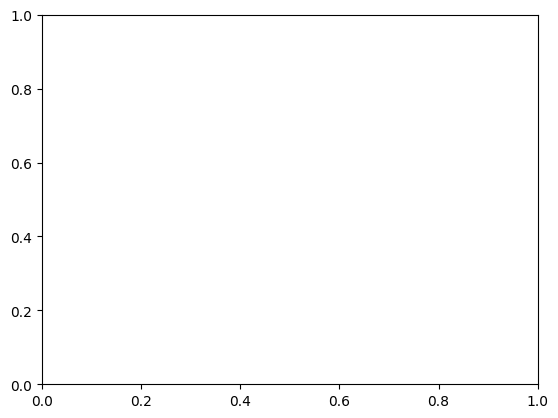

In [107]:
colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
for curve_type, color in colors.items():
    curve_row = curve_df_qd[curve_df_qd['type'] == curve_type]
    if curve_row.empty:
        continue
    rates = curve_row.iloc[0, 2:].values
    plt.plot(plot_points_yr, rates, color=color, label=curve_type)

In [108]:
plot_points_yr = np.arange(.01,30,.01)

In [109]:
plot_points_yr

array([1.000e-02, 2.000e-02, 3.000e-02, ..., 2.997e+01, 2.998e+01,
       2.999e+01])

In [110]:
curve_df_qd.iloc[0, 2:].values

array([array([36582.98083504, 36646.93702943, 36738.87405886, 36921.        ,
              37286.        , 38016.        , 39477.        , 42399.        ,
              45321.        , 48243.        ])                               ,
       array([ 0.03155835,  0.01624841,  0.11921931,  0.04754077,  0.07429459,
               0.06200002,  0.07054359,  0.04882866,  0.12878717, -0.05907318])],
      dtype=object)

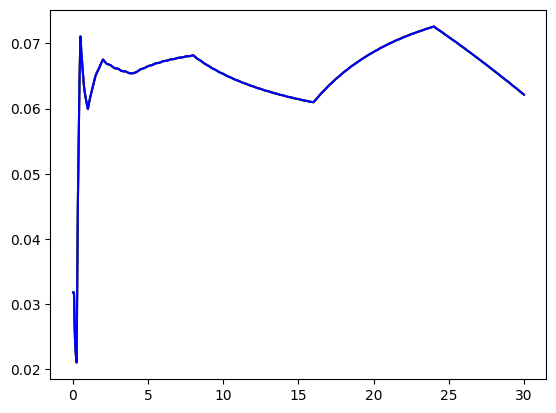

In [111]:
colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
parbd_rates_df, parbd_prices_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, 'parbond',
                                                      twostep=True, parmflag=True, padj=False)

for curve_type, color in colors.items():
    curve_row = parbd_rates_df[parbd_rates_df['type'] == curve_type]
    if curve_row.empty:
        continue
    rates = parbd_rates_df.iloc[0, 2:].values
    plt.plot(plot_points_yr, rates, color=color, label=curve_type)

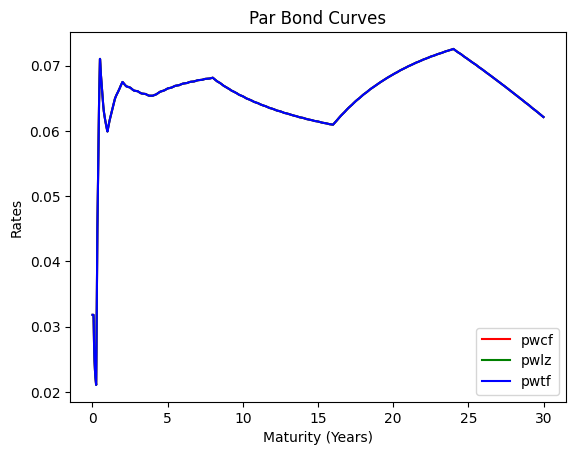

In [112]:
colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
parbd_rates_df, parbd_prices_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, 'parbond',
                                                      twostep=True, parmflag=True, padj=False)

for curve_type, color in colors.items():
    curve_row = parbd_rates_df[parbd_rates_df['type'] == curve_type]
    if curve_row.empty:
        continue
    rates = parbd_rates_df.iloc[0, 2:].values
    plt.plot(plot_points_yr, rates, color=color, label=curve_type)

plt.legend()
plt.title('Par Bond Curves')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rates')
plt.show()

In [113]:
rates

array([0.03180864571922233, 0.03180864571921209, 0.031808645719215406,
       ..., 0.0621707305349041, 0.06215600613688299, 0.06213636272906222],
      dtype=object)

In [114]:
curve_row = parbd_rates_df[parbd_rates_df['type'] == curve_type]
if curve_row.empty:
    continue

rates = parbd_rates_df.iloc[0, 2:].values

SyntaxError: 'continue' not properly in loop (<ipython-input-114-1578b7e11f1b>, line 3)

In [115]:
curve_row = parbd_rates_df[parbd_rates_df['type'] == curve_type]

In [116]:
curve_row

,type,quotedate,0.01YR,0.02YR,0.03YR,0.04YR,0.05YR,0.060000000000000005YR,0.06999999999999999YR,0.08YR,...,29.900000000000002YR,29.910000000000004YR,29.92YR,29.930000000000003YR,29.94YR,29.950000000000003YR,29.96YR,29.970000000000002YR,29.98YR,29.990000000000002YR
2,pwtf,[36555.0],0.046167,0.047479,0.049229,0.050981,0.052296,0.05405,0.055806,0.058573,...,0.048213,0.048134,0.048075,0.047996,0.047916,0.047856,0.047776,0.047696,0.047635,0.047555


In [117]:
colors.items()

dict_items([('pwcf', 'red'), ('pwlz', 'green'), ('pwtf', 'blue')])

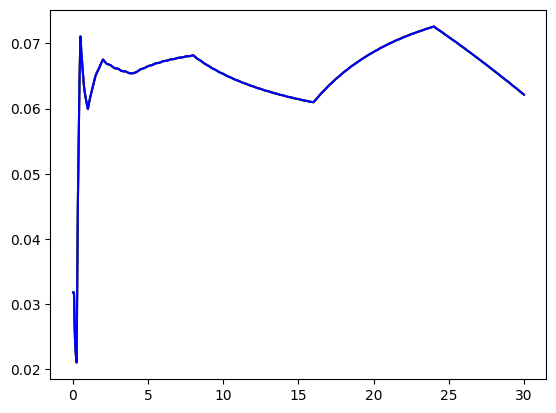

In [118]:
for curve_type, color in colors.items():
    curve_row = parbd_rates_df[parbd_rates_df['type'] == curve_type]
    # if curve_row.empty:
    #     continue
    rates = parbd_rates_df.iloc[0, 2:].values
    plt.plot(plot_points_yr, rates, color=color, label=curve_type)

In [119]:
parbd_rates_df

,type,quotedate,0.01YR,0.02YR,0.03YR,0.04YR,0.05YR,0.060000000000000005YR,0.06999999999999999YR,0.08YR,...,29.900000000000002YR,29.910000000000004YR,29.92YR,29.930000000000003YR,29.94YR,29.950000000000003YR,29.96YR,29.970000000000002YR,29.98YR,29.990000000000002YR
0,pwcf,[36555.0],0.031809,0.031809,0.031809,0.031809,0.031809,0.031809,0.031809,0.031262,...,0.062298,0.062279,0.062264,0.062244,0.062225,0.062210,0.062190,0.062171,0.062156,0.062136
1,pwlz,[36555.0],0.084815,0.084815,0.084815,0.084815,0.084815,0.084815,0.084815,0.083703,...,0.065101,0.065101,0.065102,0.065103,0.065104,0.065104,0.065106,0.065107,0.065108,0.065109
2,pwtf,[36555.0],0.046167,0.047479,0.049229,0.050981,0.052296,0.054050,0.055806,0.058573,...,0.048213,0.048134,0.048075,0.047996,0.047916,0.047856,0.047776,0.047696,0.047635,0.047555


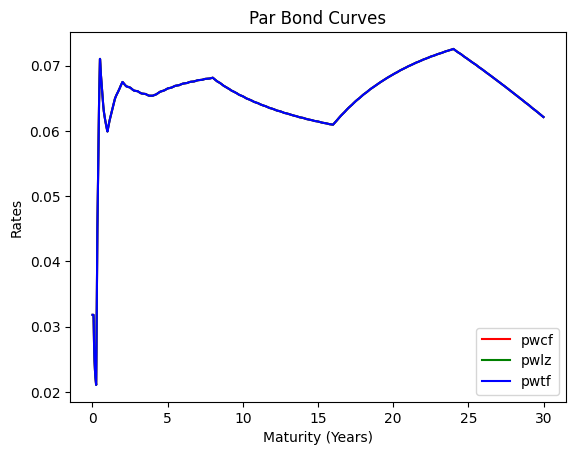

In [120]:
for curve_type, color in colors.items():
    curve_row = parbd_rates_df[parbd_rates_df['type'] == curve_type]
    # if curve_row.empty:
    #     continue
    rates = parbd_rates_df.iloc[0, 2:].values
    plt.plot(plot_points_yr, rates, color=color, label=curve_type)

plt.legend()
plt.title('Par Bond Curves')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rates')
plt.show()

In [121]:
colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
rates_df, prices_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, rate_type,
                                              twostep=True, parmflag=True, padj=False)

NameError: name 'rate_type' is not defined

In [122]:
rate_type = 'parbond'

In [123]:
colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
rates_df, prices_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, rate_type,
                                              twostep=True, parmflag=True, padj=False)

In [124]:
twostep=False

In [125]:
parmflag=True

In [126]:
padj=False

In [127]:
colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
rate_df, price_df = produce_pb_zb_anty_dfs(curve_df_qd, rate_breaks_yr, rate_type, twostep, parmflag, padj)

In [128]:
rate_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.030854,0.070818,0.060043,0.064872,0.067556,0.066111,0.065388,0.066530,0.067779,0.065317,0.061451,0.068700
1,pwlz,[36555.0],0.083776,0.060890,0.063511,0.064934,0.066683,0.067137,0.067575,0.067815,0.068200,0.068458,0.068578,0.067083
2,pwtf,[36555.0],0.060855,0.044109,0.066819,0.066316,0.065181,0.066383,0.067270,0.067731,0.068043,0.067303,0.066981,0.071498


ValueError: x and y must have same first dimension, but have shapes (2999,) and (12,)

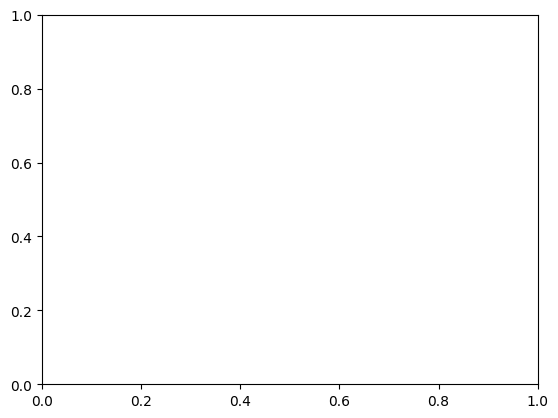

In [129]:
for curve_type, color in colors.items():
    curve_row = rate_df[rate_df['type'] == curve_type]
    if curve_row.empty:
        continue
    rates = rate_df.iloc[0, 2:].values
    plt.plot(plot_points_yr, rates, color=color, label=curve_type)

plt.legend()
plt.title(f'{rate_type} Curves')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rates')
plt.show()

In [130]:
for curve_type, color in colors.items():
    curve_row = rate_df[rate_df['type'] == curve_type]
    print(curve_row)

   type  quotedate  0.0833YR     0.5YR     1.0YR     1.5YR     2.0YR  \
0  pwcf  [36555.0]  0.030854  0.070818  0.060043  0.064872  0.067556   

      3.0YR     4.0YR    5.0YR     7.0YR    10.0YR    15.0YR  20.0YR  
0  0.066111  0.065388  0.06653  0.067779  0.065317  0.061451  0.0687  
   type  quotedate  0.0833YR    0.5YR     1.0YR     1.5YR     2.0YR     3.0YR  \
1  pwlz  [36555.0]  0.083776  0.06089  0.063511  0.064934  0.066683  0.067137   

      4.0YR     5.0YR   7.0YR    10.0YR    15.0YR    20.0YR  
1  0.067575  0.067815  0.0682  0.068458  0.068578  0.067083  
   type  quotedate  0.0833YR     0.5YR     1.0YR     1.5YR     2.0YR  \
2  pwtf  [36555.0]  0.060855  0.044109  0.066819  0.066316  0.065181   

      3.0YR    4.0YR     5.0YR     7.0YR    10.0YR    15.0YR    20.0YR  
2  0.066383  0.06727  0.067731  0.068043  0.067303  0.066981  0.071498  


In [131]:
for curve_type, color in colors.items():
    curve_row = rate_df[rate_df['type'] == curve_type]
    if curve_row.empty:
        continue
    rates = rate_df.iloc[0, 2:].values
    print(rates)

[0.03085407451084342 0.07081841738263667 0.060042553610400916
 0.06487187339379853 0.06755590250487167 0.06611105158003795
 0.06538796265049487 0.06653035370029574 0.06777875913981192
 0.06531748133750216 0.061450691667193524 0.06869974303620621]
[0.03085407451084342 0.07081841738263667 0.060042553610400916
 0.06487187339379853 0.06755590250487167 0.06611105158003795
 0.06538796265049487 0.06653035370029574 0.06777875913981192
 0.06531748133750216 0.061450691667193524 0.06869974303620621]
[0.03085407451084342 0.07081841738263667 0.060042553610400916
 0.06487187339379853 0.06755590250487167 0.06611105158003795
 0.06538796265049487 0.06653035370029574 0.06777875913981192
 0.06531748133750216 0.061450691667193524 0.06869974303620621]


In [132]:
parbd_rates_df

,type,quotedate,0.01YR,0.02YR,0.03YR,0.04YR,0.05YR,0.060000000000000005YR,0.06999999999999999YR,0.08YR,...,29.900000000000002YR,29.910000000000004YR,29.92YR,29.930000000000003YR,29.94YR,29.950000000000003YR,29.96YR,29.970000000000002YR,29.98YR,29.990000000000002YR
0,pwcf,[36555.0],0.031809,0.031809,0.031809,0.031809,0.031809,0.031809,0.031809,0.031262,...,0.062298,0.062279,0.062264,0.062244,0.062225,0.062210,0.062190,0.062171,0.062156,0.062136
1,pwlz,[36555.0],0.084815,0.084815,0.084815,0.084815,0.084815,0.084815,0.084815,0.083703,...,0.065101,0.065101,0.065102,0.065103,0.065104,0.065104,0.065106,0.065107,0.065108,0.065109
2,pwtf,[36555.0],0.046167,0.047479,0.049229,0.050981,0.052296,0.054050,0.055806,0.058573,...,0.048213,0.048134,0.048075,0.047996,0.047916,0.047856,0.047776,0.047696,0.047635,0.047555


In [133]:
rate_type

'parbond'

In [134]:
curve_type

'pwtf'

In [135]:
colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
rate_df, price_df = produce_pb_zb_anty_dfs(curve_df_qd, rate_breaks_yr, rate_type, twostep, parmflag, padj)
for ctype, color in colors.items():
    curve_row = rate_df[rate_df['type'] == ctype]
    if curve_row.empty:
        continue
    rates = rate_df.iloc[0, 2:].values
    print(rates)

[0.03085407451084342 0.07081841738263667 0.060042553610400916
 0.06487187339379853 0.06755590250487167 0.06611105158003795
 0.06538796265049487 0.06653035370029574 0.06777875913981192
 0.06531748133750216 0.061450691667193524 0.06869974303620621]
[0.03085407451084342 0.07081841738263667 0.060042553610400916
 0.06487187339379853 0.06755590250487167 0.06611105158003795
 0.06538796265049487 0.06653035370029574 0.06777875913981192
 0.06531748133750216 0.061450691667193524 0.06869974303620621]
[0.03085407451084342 0.07081841738263667 0.060042553610400916
 0.06487187339379853 0.06755590250487167 0.06611105158003795
 0.06538796265049487 0.06653035370029574 0.06777875913981192
 0.06531748133750216 0.061450691667193524 0.06869974303620621]


In [136]:
rate_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.030854,0.070818,0.060043,0.064872,0.067556,0.066111,0.065388,0.066530,0.067779,0.065317,0.061451,0.068700
1,pwlz,[36555.0],0.083776,0.060890,0.063511,0.064934,0.066683,0.067137,0.067575,0.067815,0.068200,0.068458,0.068578,0.067083
2,pwtf,[36555.0],0.060855,0.044109,0.066819,0.066316,0.065181,0.066383,0.067270,0.067731,0.068043,0.067303,0.066981,0.071498


In [137]:
colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
rate_df, price_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, rate_type, twostep, parmflag, padj)

In [138]:
rate_df

,type,quotedate,0.01YR,0.02YR,0.03YR,0.04YR,0.05YR,0.060000000000000005YR,0.06999999999999999YR,0.08YR,...,29.900000000000002YR,29.910000000000004YR,29.92YR,29.930000000000003YR,29.94YR,29.950000000000003YR,29.96YR,29.970000000000002YR,29.98YR,29.990000000000002YR
0,pwcf,[36555.0],0.032304,0.032300,0.032294,0.032288,0.032284,0.032278,0.032273,0.031360,...,0.062306,0.062286,0.062268,0.062248,0.062227,0.062212,0.062192,0.062171,0.062156,0.062135
1,pwlz,[36555.0],0.087305,0.087274,0.087232,0.087191,0.087160,0.087118,0.087077,0.084911,...,0.065109,0.065110,0.065106,0.065106,0.065106,0.065107,0.065107,0.065107,0.065108,0.065108
2,pwtf,[36555.0],0.047056,0.048400,0.050192,0.051986,0.053332,0.055127,0.056923,0.059099,...,0.048218,0.048139,0.048078,0.047998,0.047918,0.047858,0.047777,0.047696,0.047636,0.047554


In [139]:
for ctype, color in colors.items():
    curve_row = rate_df[rate_df['type'] == ctype]
    if curve_row.empty:
        continue
    rates = rate_df.iloc[0, 2:].values
    print(rates)

[0.03230393896089492 0.03229968526927651 0.03229401485139673 ...
 0.0621710653630613 0.06215569680378822 0.06213516679546644]
[0.03230393896089492 0.03229968526927651 0.03229401485139673 ...
 0.0621710653630613 0.06215569680378822 0.06213516679546644]
[0.03230393896089492 0.03229968526927651 0.03229401485139673 ...
 0.0621710653630613 0.06215569680378822 0.06213516679546644]


In [140]:
rate_df

,type,quotedate,0.01YR,0.02YR,0.03YR,0.04YR,0.05YR,0.060000000000000005YR,0.06999999999999999YR,0.08YR,...,29.900000000000002YR,29.910000000000004YR,29.92YR,29.930000000000003YR,29.94YR,29.950000000000003YR,29.96YR,29.970000000000002YR,29.98YR,29.990000000000002YR
0,pwcf,[36555.0],0.032304,0.032300,0.032294,0.032288,0.032284,0.032278,0.032273,0.031360,...,0.062306,0.062286,0.062268,0.062248,0.062227,0.062212,0.062192,0.062171,0.062156,0.062135
1,pwlz,[36555.0],0.087305,0.087274,0.087232,0.087191,0.087160,0.087118,0.087077,0.084911,...,0.065109,0.065110,0.065106,0.065106,0.065106,0.065107,0.065107,0.065107,0.065108,0.065108
2,pwtf,[36555.0],0.047056,0.048400,0.050192,0.051986,0.053332,0.055127,0.056923,0.059099,...,0.048218,0.048139,0.048078,0.047998,0.047918,0.047858,0.047777,0.047696,0.047636,0.047554


In [141]:
for curvetype, color in colors.items():
    curve_row = rate_df[rate_df['type'] == curvetype]
    if curve_row.empty:
        continue
    rates = curve_row.iloc[0, 2:].values
    print(rates)

[0.03230393896089492 0.03229968526927651 0.03229401485139673 ...
 0.0621710653630613 0.06215569680378822 0.06213516679546644]
[0.08730464991374655 0.08727357967131927 0.0872321760931106 ...
 0.06510725088917971 0.06510757415848009 0.0651080633735043]
[0.04705632406839105 0.04839983586649912 0.050192249668076325 ...
 0.047696293501627816 0.04763554495021733 0.047554332563812904]


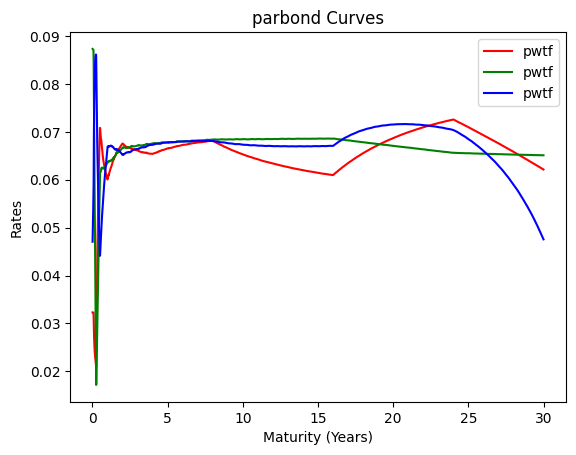

In [142]:
for curvetype, color in colors.items():
    curve_row = rate_df[rate_df['type'] == curvetype]
    if curve_row.empty:
        continue
    rates = curve_row.iloc[0, 2:].values
    plt.plot(plot_points_yr, rates, color=color, label=curve_type)

plt.legend()
plt.title(f'{rate_type} Curves')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rates')
plt.show()

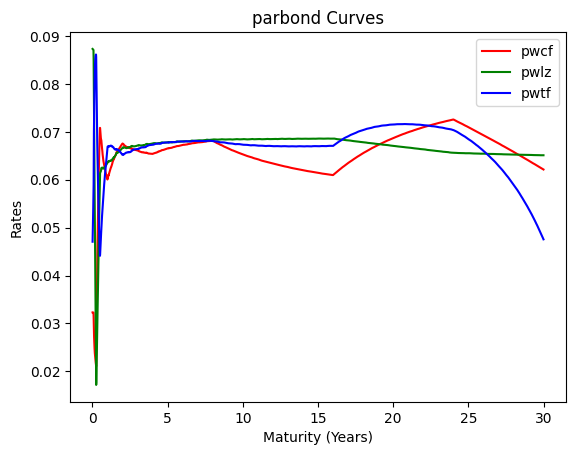

In [143]:
for curvetype, color in colors.items():
    curve_row = rate_df[rate_df['type'] == curvetype]
    if curve_row.empty:
        continue
    rates = curve_row.iloc[0, 2:].values
    plt.plot(plot_points_yr, rates, color=color, label=curvetype)

plt.legend()
plt.title(f'{rate_type} Curves')
plt.xlabel('Maturity (Years)')
plt.ylabel('Rates')
plt.show()

In [144]:
quote_date = 36555.0
rate_type = 'zerobond'
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type)

NameError: name 'plot_pb_zb_anty_curve' is not defined

In [145]:
def plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type, twostep=False, parmflag=True, padj=False):
    """
    This function takes in input curves (breaks, rates) and plots par bond curves 
    at a quarterly frequency. It plots 3 types of curves all at once.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curves data.
        plot_points_yr (list): List of maturities (in years) for which the rates are to be calculated.
        quote_date(float): Quote date, in the form of julian date, e.g., quote_date = 36555.0
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    """
    colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
    curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
    rate_df, price_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, rate_type, twostep, parmflag, padj)
    for curvetype, color in colors.items():
        curve_row = rate_df[rate_df['type'] == curvetype]
        if curve_row.empty:
            continue
        rates = curve_row.iloc[0, 2:].values
        plt.plot(plot_points_yr, rates, color=color, label=curvetype)
    plt.legend()
    plt.title(f'{rate_type} Curves, {quote_date}')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Rates')
    # plt.savefig(f"../../output/{rate_type}_curves_{quote_date}.png")
    plt.show()

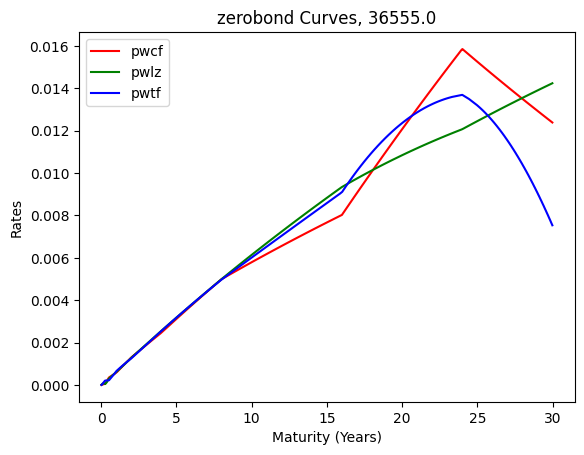

In [146]:
quote_date = 36555.0
rate_type = 'zerobond'
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type)

In [147]:
parbd_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
zerobd_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])
annuity_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])

In [148]:
def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    """Take in an input curve (breaks, rates) and maturities for calculating zero bond rates and prices. """
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    zbrates = df_maturity.copy()/100.
    # for j in range(len(zbrates)):
        # zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j],
        #                                              parmflag=True, padj=False)
    discount_curve = df.discFact(zerobd_breaks_yr,curve)
    zbrates = np.log(discount_curve)/(-zerobd_breaks_yr)
    return zbrates, df_maturity

In [149]:
def produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, rate_type, twostep=False,
                            parmflag=True, padj=False):
    """
    Generate dataframes for par bond, zero bond, or annuity rates and prices from a given yield curve dataframe.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curve information with columns ['type', 'quotedate', 'breaks', 'rates'].
        rate_breaks_yr (list): List of maturities (in years) for which the rates are to be calculated.
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    Returns:
        rates_df (pd.DataFrame): DataFrame containing the calculated rates with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
        prices_df (pd.DataFrame): DataFrame containing the corresponding bond prices with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
    Raises:
        ValueError: If rate_type is not one of 'parbond', 'zerobond', or 'annuity'.
    """
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        if rate_type == 'parbond':
            rate, price = parbond_rates(curve, rate_breaks_yr, twostep, parmflag, padj)
        elif rate_type == 'zerobond':
            rate, price = zerobond_rates(curve, rate_breaks_yr, parmflag, padj)
        elif rate_type == 'annuity':
            rate, price = annuity_rates(curve, rate_breaks_yr, parmflag, padj)
        else:
            raise ValueError("rate_type must be one of 'parbond', 'zerobond', or 'annuity'")
        rates.append([curve[0], curve[1]] + list(rate))
        prices.append([curve[0], curve[1]] + list(price))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr]
    rates_df = pd.DataFrame(rates, columns=columns)
    prices_df = pd.DataFrame(prices, columns=columns)
    return rates_df, prices_df

In [150]:
zerobd_rates_df, zerobd_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'zerobond',
                                                            parmflag=True, padj=False)

<ipython-input-148-b1faa19b992a>:16: RuntimeWarning: divide by zero encountered in log
  zbrates = np.log(discount_curve)/(-zerobd_breaks_yr)


In [151]:
zerobd_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],-37.916203,-6.316767,-3.158341,-2.105532,-1.579127,-1.052723,-0.789520,-0.631599,-0.451117,-0.315756,-0.210475,-0.157835
1,pwcf,[36584.0],-52.110544,-8.681518,-4.340700,-2.893760,-2.170290,-1.446821,-1.085086,-0.868045,-0.619998,-0.433963,-0.289269,-0.216922
2,pwlz,[36555.0],-181.529745,-30.242356,-15.120878,-10.080385,-7.560139,-5.039893,-3.779770,-3.023696,-2.159611,-1.511548,-1.007499,-0.755474
3,pwlz,[36584.0],-387.926293,-64.627297,-32.312915,-21.541454,-16.155724,-10.769993,-8.077128,-6.461409,-4.614873,-3.229971,-2.152825,-1.614252
4,pwtf,[36555.0],inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
5,pwtf,[36584.0],inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [152]:
def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    """Take in an input curve (breaks, rates) and maturities for calculating zero bond rates and prices. """
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    # zbrates = df_maturity.copy()/100.
    # for j in range(len(zbrates)):
        # zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j],
        #                                              parmflag=True, padj=False)
    discount_curve = df.discFact(plot_points,curve)
    zbrates = np.log(discount_curve)/(-plot_points)
    return zbrates, df_maturity

In [153]:
def produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, rate_type, twostep=False,
                            parmflag=True, padj=False):
    """
    Generate dataframes for par bond, zero bond, or annuity rates and prices from a given yield curve dataframe.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curve information with columns ['type', 'quotedate', 'breaks', 'rates'].
        rate_breaks_yr (list): List of maturities (in years) for which the rates are to be calculated.
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    Returns:
        rates_df (pd.DataFrame): DataFrame containing the calculated rates with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
        prices_df (pd.DataFrame): DataFrame containing the corresponding bond prices with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
    Raises:
        ValueError: If rate_type is not one of 'parbond', 'zerobond', or 'annuity'.
    """
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        if rate_type == 'parbond':
            rate, price = parbond_rates(curve, rate_breaks_yr, twostep, parmflag, padj)
        elif rate_type == 'zerobond':
            rate, price = zerobond_rates(curve, rate_breaks_yr, parmflag, padj)
        elif rate_type == 'annuity':
            rate, price = annuity_rates(curve, rate_breaks_yr, parmflag, padj)
        else:
            raise ValueError("rate_type must be one of 'parbond', 'zerobond', or 'annuity'")
        rates.append([curve[0], curve[1]] + list(rate))
        prices.append([curve[0], curve[1]] + list(price))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr]
    rates_df = pd.DataFrame(rates, columns=columns)
    prices_df = pd.DataFrame(prices, columns=columns)
    return rates_df, prices_df

In [154]:
zerobd_rates_df, zerobd_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'zerobond',
                                                            parmflag=True, padj=False)

In [155]:
zerobd_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],6.853698e-08,9.523142e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000016,0.000021,0.000033
1,pwcf,[36584.0],1.029346e-07,7.985115e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000029
2,pwlz,[36555.0],1.817431e-07,8.206623e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000017,0.000024,0.000030
3,pwlz,[36584.0],2.332949e-07,8.665677e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000022,0.000030
4,pwtf,[36555.0],1.333690e-07,5.969880e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000034
5,pwtf,[36584.0],6.495138e-08,5.575007e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000008,0.000011,0.000017,0.000026,0.000030


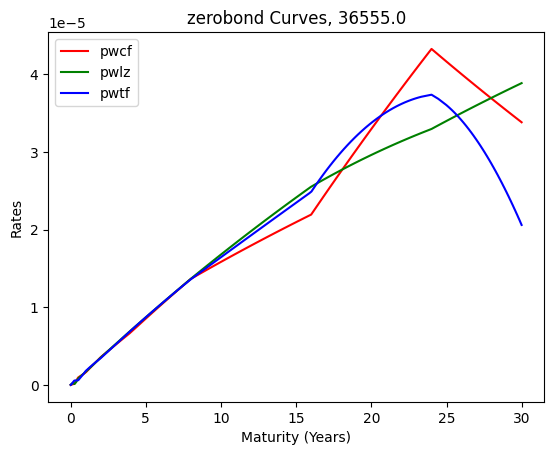

In [156]:
quote_date = 36555.0
rate_type = 'zerobond'
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type)

In [157]:
def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    """Take in an input curve (breaks, rates) and maturities for calculating annuity rates and prices. """
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    # annuityrates = pv_annuity.copy()/100.
    # for j in range(len(annuityrates)):
    #     annuityrates[j] = pv.bondYieldFromPrice_callable(
    #         pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    discount_curve = df.discFact(plot_points,curve)
    annuityrates = np.log(discount_curve)/(-plot_points)
    return annuityrates, pv_annuity

In [158]:
def produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, rate_type, twostep=False,
                            parmflag=True, padj=False):
    """
    Generate dataframes for par bond, zero bond, or annuity rates and prices from a given yield curve dataframe.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curve information with columns ['type', 'quotedate', 'breaks', 'rates'].
        rate_breaks_yr (list): List of maturities (in years) for which the rates are to be calculated.
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    Returns:
        rates_df (pd.DataFrame): DataFrame containing the calculated rates with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
        prices_df (pd.DataFrame): DataFrame containing the corresponding bond prices with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
    Raises:
        ValueError: If rate_type is not one of 'parbond', 'zerobond', or 'annuity'.
    """
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        if rate_type == 'parbond':
            rate, price = parbond_rates(curve, rate_breaks_yr, twostep, parmflag, padj)
        elif rate_type == 'zerobond':
            rate, price = zerobond_rates(curve, rate_breaks_yr, parmflag, padj)
        elif rate_type == 'annuity':
            rate, price = annuity_rates(curve, rate_breaks_yr, parmflag, padj)
        else:
            raise ValueError("rate_type must be one of 'parbond', 'zerobond', or 'annuity'")
        rates.append([curve[0], curve[1]] + list(rate))
        prices.append([curve[0], curve[1]] + list(price))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr]
    rates_df = pd.DataFrame(rates, columns=columns)
    prices_df = pd.DataFrame(prices, columns=columns)
    return rates_df, prices_df

In [159]:
annuity_rates_df, annuity_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'annuity',
                                                              parmflag=True, padj=False)

In [160]:
annuity_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],6.853698e-08,9.523142e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000016,0.000021,0.000033
1,pwcf,[36584.0],1.029346e-07,7.985115e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000029
2,pwlz,[36555.0],1.817431e-07,8.206623e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000017,0.000024,0.000030
3,pwlz,[36584.0],2.332949e-07,8.665677e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000022,0.000030
4,pwtf,[36555.0],1.333690e-07,5.969880e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000034
5,pwtf,[36584.0],6.495138e-08,5.575007e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000008,0.000011,0.000017,0.000026,0.000030


In [161]:
zerobd_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],6.853698e-08,9.523142e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000016,0.000021,0.000033
1,pwcf,[36584.0],1.029346e-07,7.985115e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000029
2,pwlz,[36555.0],1.817431e-07,8.206623e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000017,0.000024,0.000030
3,pwlz,[36584.0],2.332949e-07,8.665677e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000022,0.000030
4,pwtf,[36555.0],1.333690e-07,5.969880e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000034
5,pwtf,[36584.0],6.495138e-08,5.575007e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000008,0.000011,0.000017,0.000026,0.000030


In [162]:
zerobd_rates_df, zerobd_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'zerobond',
                                                            parmflag=True, padj=False)

In [163]:
zerobd_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],6.853698e-08,9.523142e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000016,0.000021,0.000033
1,pwcf,[36584.0],1.029346e-07,7.985115e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000029
2,pwlz,[36555.0],1.817431e-07,8.206623e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000017,0.000024,0.000030
3,pwlz,[36584.0],2.332949e-07,8.665677e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000022,0.000030
4,pwtf,[36555.0],1.333690e-07,5.969880e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000034
5,pwtf,[36584.0],6.495138e-08,5.575007e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000008,0.000011,0.000017,0.000026,0.000030


In [164]:
def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    """Take in an input curve (breaks, rates) and maturities for calculating annuity rates and prices. """
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates, pv_annuity

In [165]:
def produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, rate_type, twostep=False,
                            parmflag=True, padj=False):
    """
    Generate dataframes for par bond, zero bond, or annuity rates and prices from a given yield curve dataframe.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curve information with columns ['type', 'quotedate', 'breaks', 'rates'].
        rate_breaks_yr (list): List of maturities (in years) for which the rates are to be calculated.
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    Returns:
        rates_df (pd.DataFrame): DataFrame containing the calculated rates with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
        prices_df (pd.DataFrame): DataFrame containing the corresponding bond prices with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
    Raises:
        ValueError: If rate_type is not one of 'parbond', 'zerobond', or 'annuity'.
    """
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        if rate_type == 'parbond':
            rate, price = parbond_rates(curve, rate_breaks_yr, twostep, parmflag, padj)
        elif rate_type == 'zerobond':
            rate, price = zerobond_rates(curve, rate_breaks_yr, parmflag, padj)
        elif rate_type == 'annuity':
            rate, price = annuity_rates(curve, rate_breaks_yr, parmflag, padj)
        else:
            raise ValueError("rate_type must be one of 'parbond', 'zerobond', or 'annuity'")
        rates.append([curve[0], curve[1]] + list(rate))
        prices.append([curve[0], curve[1]] + list(price))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr]
    rates_df = pd.DataFrame(rates, columns=columns)
    prices_df = pd.DataFrame(prices, columns=columns)
    return rates_df, prices_df

In [166]:
zerobd_rates_df, zerobd_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'zerobond',
                                                            parmflag=True, padj=False)

annuity_rates_df, annuity_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'annuity',
                                                              parmflag=True, padj=False)

In [167]:
zerobd_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],6.853698e-08,9.523142e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000016,0.000021,0.000033
1,pwcf,[36584.0],1.029346e-07,7.985115e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000029
2,pwlz,[36555.0],1.817431e-07,8.206623e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000017,0.000024,0.000030
3,pwlz,[36584.0],2.332949e-07,8.665677e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000022,0.000030
4,pwtf,[36555.0],1.333690e-07,5.969880e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000034
5,pwtf,[36584.0],6.495138e-08,5.575007e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000008,0.000011,0.000017,0.000026,0.000030


In [168]:
annuity_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],4.344500,1.690187,1.792394,0.665001,0.694820,0.440326,0.327363,0.264192,0.195824,0.147121,0.109716,0.093387
1,pwcf,[36584.0],3.304015,4.637202,1.538979,0.915885,0.654895,0.349913,0.318895,0.258690,0.175668,0.145184,0.104144,0.093205
2,pwlz,[36555.0],4.377953,1.683928,1.790086,0.664771,0.694161,0.440378,0.328039,0.264992,0.196447,0.148040,0.112649,0.095952
3,pwlz,[36584.0],3.327262,4.659276,1.542068,0.916466,0.654583,0.349602,0.318825,0.258764,0.175535,0.144546,0.103477,0.092944
4,pwtf,[36555.0],4.363618,1.672856,1.783982,0.664180,0.693013,0.439536,0.327467,0.264622,0.196227,0.147661,0.111807,0.096295
5,pwtf,[36584.0],3.297278,4.560088,1.533802,0.914218,0.653042,0.349283,0.318767,0.258503,0.174896,0.144502,0.106036,0.096263


In [169]:
def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    """Take in an input curve (breaks, rates) and maturities for calculating zero bond rates and prices. """
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    zbrates = df_maturity.copy()/100.
    for j in range(len(zbrates)):
        zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j],
                                                     parmflag=True, padj=False)
    # discount_curve = df.discFact(plot_points,curve)
    # zbrates = np.log(discount_curve)/(-plot_points)
    return zbrates, df_maturity

In [170]:
def produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, rate_type, twostep=False,
                            parmflag=True, padj=False):
    """
    Generate dataframes for par bond, zero bond, or annuity rates and prices from a given yield curve dataframe.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curve information with columns ['type', 'quotedate', 'breaks', 'rates'].
        rate_breaks_yr (list): List of maturities (in years) for which the rates are to be calculated.
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    Returns:
        rates_df (pd.DataFrame): DataFrame containing the calculated rates with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
        prices_df (pd.DataFrame): DataFrame containing the corresponding bond prices with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
    Raises:
        ValueError: If rate_type is not one of 'parbond', 'zerobond', or 'annuity'.
    """
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        if rate_type == 'parbond':
            rate, price = parbond_rates(curve, rate_breaks_yr, twostep, parmflag, padj)
        elif rate_type == 'zerobond':
            rate, price = zerobond_rates(curve, rate_breaks_yr, parmflag, padj)
        elif rate_type == 'annuity':
            rate, price = annuity_rates(curve, rate_breaks_yr, parmflag, padj)
        else:
            raise ValueError("rate_type must be one of 'parbond', 'zerobond', or 'annuity'")
        rates.append([curve[0], curve[1]] + list(rate))
        prices.append([curve[0], curve[1]] + list(price))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr]
    rates_df = pd.DataFrame(rates, columns=columns)
    prices_df = pd.DataFrame(prices, columns=columns)
    return rates_df, prices_df

def plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type, twostep=False, parmflag=True, padj=False):
    """
    This function takes in input curves (breaks, rates) and plots par bond curves 
    at a quarterly frequency. It plots 3 types of curves all at once.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curves data.
        plot_points_yr (list): List of maturities (in years) for which the rates are to be calculated.
        quote_date(float): Quote date, in the form of julian date, e.g., quote_date = 36555.0
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    """
    colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
    curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
    rate_df, price_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, rate_type, twostep, parmflag, padj)
    for curvetype, color in colors.items():
        curve_row = rate_df[rate_df['type'] == curvetype]
        if curve_row.empty:
            continue
        rates = curve_row.iloc[0, 2:].values
        plt.plot(plot_points_yr, rates, color=color, label=curvetype)
    plt.legend()
    plt.title(f'{rate_type} Curves, {quote_date}')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Rates')
    # plt.savefig(f"../../output/{rate_type}_curves_{quote_date}.png")
    plt.show()

In [171]:
zerobd_rates_df, zerobd_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'zerobond',
                                                            parmflag=True, padj=False)

In [172]:
zerobd_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.000025,0.000348,0.000582,0.000945,0.001305,0.001894,0.002472,0.003120,0.004383,0.005795,0.007671,0.012070
1,pwcf,[36584.0],0.000038,0.000292,0.000621,0.000945,0.001264,0.001908,0.002538,0.003133,0.004292,0.005893,0.008333,0.010534
2,pwlz,[36555.0],0.000066,0.000300,0.000617,0.000947,0.001288,0.001927,0.002562,0.003182,0.004401,0.006142,0.008833,0.010844
3,pwlz,[36584.0],0.000085,0.000317,0.000624,0.000931,0.001232,0.001892,0.002578,0.003149,0.004211,0.005756,0.008211,0.011141
4,pwtf,[36555.0],0.000049,0.000218,0.000652,0.000969,0.001259,0.001906,0.002553,0.003182,0.004394,0.006016,0.008587,0.012360
5,pwtf,[36584.0],0.000024,0.000204,0.000663,0.000951,0.001212,0.001914,0.002599,0.003087,0.004075,0.006191,0.009596,0.010814


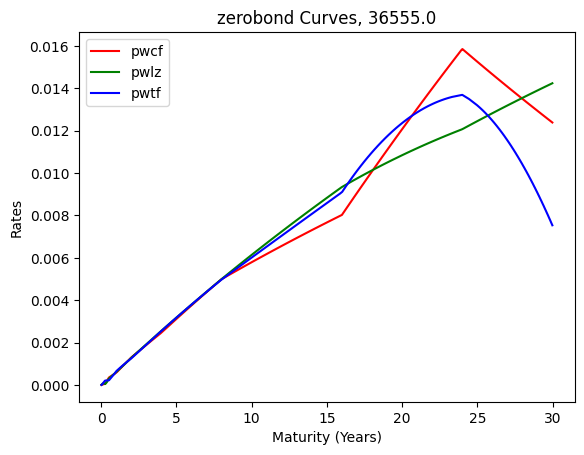

In [173]:
quote_date = 36555.0
rate_type = 'zerobond'
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type)

In [174]:
def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    """Take in an input curve (breaks, rates) and maturities for calculating zero bond rates and prices. """
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    # zbrates = df_maturity.copy()/100.
    # for j in range(len(zbrates)):
    #     zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j],
    #                                                  parmflag=True, padj=False)
    discount_curve = df.discFact(plot_points,curve)
    zbrates = np.log(discount_curve)/(-plot_points)
    return zbrates, df_maturity

In [175]:
def produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, rate_type, twostep=False,
                            parmflag=True, padj=False):
    """
    Generate dataframes for par bond, zero bond, or annuity rates and prices from a given yield curve dataframe.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curve information with columns ['type', 'quotedate', 'breaks', 'rates'].
        rate_breaks_yr (list): List of maturities (in years) for which the rates are to be calculated.
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    Returns:
        rates_df (pd.DataFrame): DataFrame containing the calculated rates with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
        prices_df (pd.DataFrame): DataFrame containing the corresponding bond prices with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
    Raises:
        ValueError: If rate_type is not one of 'parbond', 'zerobond', or 'annuity'.
    """
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        if rate_type == 'parbond':
            rate, price = parbond_rates(curve, rate_breaks_yr, twostep, parmflag, padj)
        elif rate_type == 'zerobond':
            rate, price = zerobond_rates(curve, rate_breaks_yr, parmflag, padj)
        elif rate_type == 'annuity':
            rate, price = annuity_rates(curve, rate_breaks_yr, parmflag, padj)
        else:
            raise ValueError("rate_type must be one of 'parbond', 'zerobond', or 'annuity'")
        rates.append([curve[0], curve[1]] + list(rate))
        prices.append([curve[0], curve[1]] + list(price))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr]
    rates_df = pd.DataFrame(rates, columns=columns)
    prices_df = pd.DataFrame(prices, columns=columns)
    return rates_df, prices_df

In [176]:
def plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type, twostep=False, parmflag=True, padj=False):
    """
    This function takes in input curves (breaks, rates) and plots par bond curves 
    at a quarterly frequency. It plots 3 types of curves all at once.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curves data.
        plot_points_yr (list): List of maturities (in years) for which the rates are to be calculated.
        quote_date(float): Quote date, in the form of julian date, e.g., quote_date = 36555.0
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    """
    colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
    curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
    rate_df, price_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, rate_type, twostep, parmflag, padj)
    for curvetype, color in colors.items():
        curve_row = rate_df[rate_df['type'] == curvetype]
        if curve_row.empty:
            continue
        rates = curve_row.iloc[0, 2:].values
        plt.plot(plot_points_yr, rates, color=color, label=curvetype)
    plt.legend()
    plt.title(f'{rate_type} Curves, {quote_date}')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Rates')
    # plt.savefig(f"../../output/{rate_type}_curves_{quote_date}.png")
    plt.show()

In [177]:
zerobd_rates_df, zerobd_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'zerobond',
                                                            parmflag=True, padj=False)

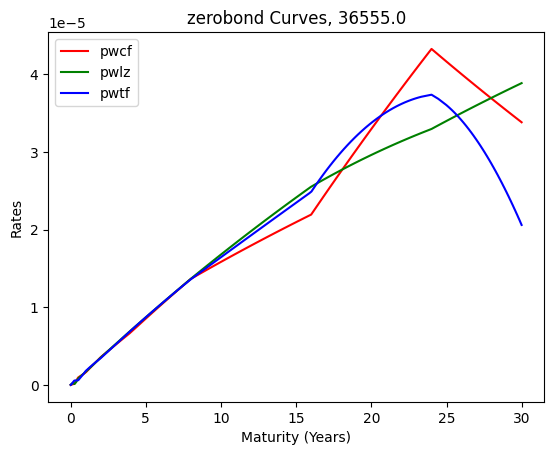

In [178]:
quote_date = 36555.0
rate_type = 'zerobond'
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type)

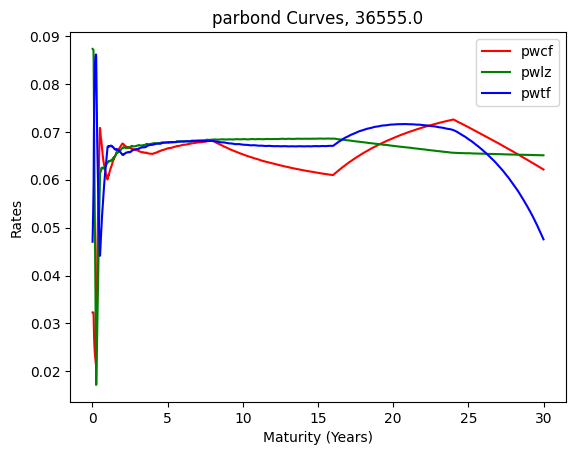

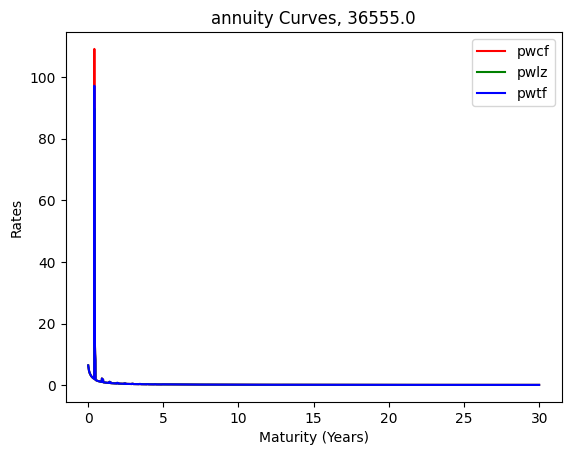

In [179]:
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, 'parbond')
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, 'annuity')

In [180]:
parbd_rates_df

,type,quotedate,0.01YR,0.02YR,0.03YR,0.04YR,0.05YR,0.060000000000000005YR,0.06999999999999999YR,0.08YR,...,29.900000000000002YR,29.910000000000004YR,29.92YR,29.930000000000003YR,29.94YR,29.950000000000003YR,29.96YR,29.970000000000002YR,29.98YR,29.990000000000002YR
0,pwcf,[36555.0],0.031809,0.031809,0.031809,0.031809,0.031809,0.031809,0.031809,0.031262,...,0.062298,0.062279,0.062264,0.062244,0.062225,0.062210,0.062190,0.062171,0.062156,0.062136
1,pwlz,[36555.0],0.084815,0.084815,0.084815,0.084815,0.084815,0.084815,0.084815,0.083703,...,0.065101,0.065101,0.065102,0.065103,0.065104,0.065104,0.065106,0.065107,0.065108,0.065109
2,pwtf,[36555.0],0.046167,0.047479,0.049229,0.050981,0.052296,0.054050,0.055806,0.058573,...,0.048213,0.048134,0.048075,0.047996,0.047916,0.047856,0.047776,0.047696,0.047635,0.047555


In [181]:
zerobd_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],6.853698e-08,9.523142e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000016,0.000021,0.000033
1,pwcf,[36584.0],1.029346e-07,7.985115e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000029
2,pwlz,[36555.0],1.817431e-07,8.206623e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000017,0.000024,0.000030
3,pwlz,[36584.0],2.332949e-07,8.665677e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000022,0.000030
4,pwtf,[36555.0],1.333690e-07,5.969880e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000034
5,pwtf,[36584.0],6.495138e-08,5.575007e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000008,0.000011,0.000017,0.000026,0.000030


In [182]:
annuity_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],4.344500,1.690187,1.792394,0.665001,0.694820,0.440326,0.327363,0.264192,0.195824,0.147121,0.109716,0.093387
1,pwcf,[36584.0],3.304015,4.637202,1.538979,0.915885,0.654895,0.349913,0.318895,0.258690,0.175668,0.145184,0.104144,0.093205
2,pwlz,[36555.0],4.377953,1.683928,1.790086,0.664771,0.694161,0.440378,0.328039,0.264992,0.196447,0.148040,0.112649,0.095952
3,pwlz,[36584.0],3.327262,4.659276,1.542068,0.916466,0.654583,0.349602,0.318825,0.258764,0.175535,0.144546,0.103477,0.092944
4,pwtf,[36555.0],4.363618,1.672856,1.783982,0.664180,0.693013,0.439536,0.327467,0.264622,0.196227,0.147661,0.111807,0.096295
5,pwtf,[36584.0],3.297278,4.560088,1.533802,0.914218,0.653042,0.349283,0.318767,0.258503,0.174896,0.144502,0.106036,0.096263


In [183]:
def plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type, twostep=False,
                           parmflag=True, padj=False):
    """
    This function takes in input curves (breaks, rates) and plots par bond curves 
    at a quarterly frequency. It plots 3 types of curves all at once.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curves data.
        plot_points_yr (list): List of maturities (in years) for which the rates are to be calculated.
        quote_date(float): Quote date, in the form of julian date, e.g., quote_date = 36555.0
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    """
    colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
    curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
    rate_df, price_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, rate_type, twostep, parmflag, padj)
    def transform_x(x):
        """ Transform x-axis values to expand the scale for values below 4 years. """
        if x < 4:
            return x * 2
        else:
            return 4 + (x - 4)
    transformed_plot_points_yr = np.array([transform_x(x) for x in plot_points_yr])
    for curvetype, color in colors.items():
        curve_row = rate_df[rate_df['type'] == curvetype]
        if curve_row.empty:
            continue
        rates = curve_row.iloc[0, 2:].values
        plt.plot(transformed_plot_points_yr, rates, color=color, label=curvetype)
    plt.legend()
    plt.title(f'{rate_type} Curves, {quote_date}')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Rates')
    # plt.savefig(f"../../output/{rate_type}_curves_{quote_date}.png")
    plt.show()

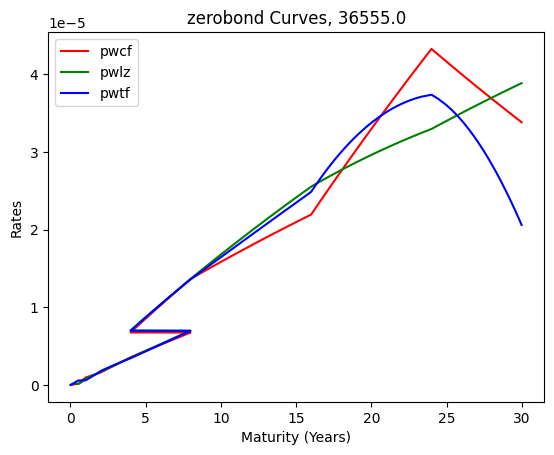

In [184]:
quote_date = 36555.0
rate_type = 'zerobond'
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type)

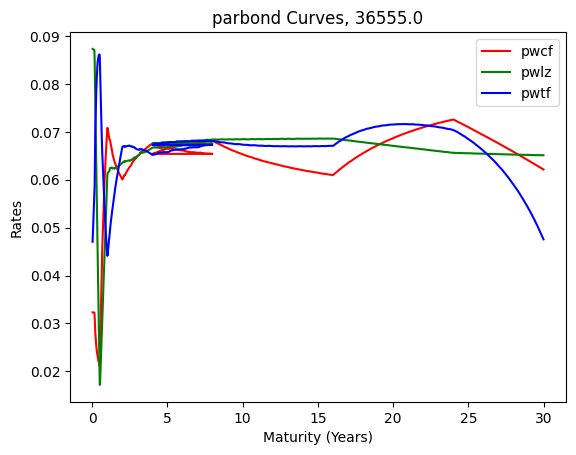

In [185]:
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, 'parbond')

In [186]:
def plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type, twostep=False,
                           parmflag=True, padj=False):
    """
    This function takes in input curves (breaks, rates) and plots par bond curves 
    at a quarterly frequency. It plots 3 types of curves all at once.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curves data.
        plot_points_yr (list): List of maturities (in years) for which the rates are to be calculated.
        quote_date(float): Quote date, in the form of julian date, e.g., quote_date = 36555.0
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    """
    colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
    curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
    rate_df, price_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, rate_type, twostep, parmflag, padj)
    # def transform_x(x):
    #     """ Transform x-axis values to expand the scale for values below 4 years. """
    #     if x < 4:
    #         return x * 2
    #     else:
    #         return 4 + (x - 4)
    # plot_points_yr = np.array([transform_x(x) for x in plot_points_yr])
    for curvetype, color in colors.items():
        curve_row = rate_df[rate_df['type'] == curvetype]
        if curve_row.empty:
            continue
        rates = curve_row.iloc[0, 2:].values
        plt.plot(plot_points_yr, rates, color=color, label=curvetype)
    plt.legend()
    plt.title(f'{rate_type} Curves, {quote_date}')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Rates')
    plt.xscale('log')
    # plt.savefig(f"../../output/{rate_type}_curves_{quote_date}.png")
    plt.show()

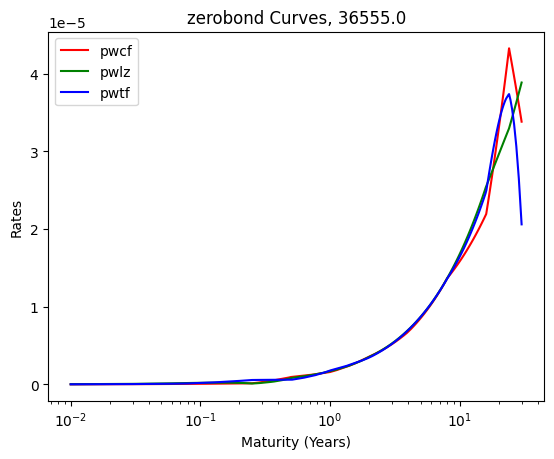

In [187]:
quote_date = 36555.0
rate_type = 'zerobond'
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type)

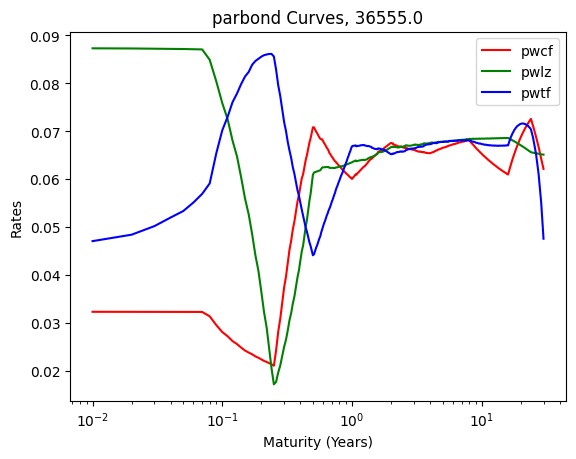

In [188]:
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, 'parbond')

In [189]:
def plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type, twostep=False,
                           parmflag=True, padj=False, log_scale=False):
    """
    This function takes in input curves (breaks, rates) and plots par bond curves 
    at a quarterly frequency. It plots 3 types of curves all at once.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curves data.
        plot_points_yr (list): List of maturities (in years) for which the rates are to be calculated.
        quote_date(float): Quote date, in the form of julian date, e.g., quote_date = 36555.0
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    """
    colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
    curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
    rate_df, price_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, rate_type, twostep, parmflag, padj)
    # def transform_x(x):
    #     """ Transform x-axis values to expand the scale for values below 4 years. """
    #     if x < 4:
    #         return x * 2
    #     else:
    #         return 4 + (x - 4)
    # plot_points_yr = np.array([transform_x(x) for x in plot_points_yr])
    for curvetype, color in colors.items():
        curve_row = rate_df[rate_df['type'] == curvetype]
        if curve_row.empty:
            continue
        rates = curve_row.iloc[0, 2:].values
        plt.plot(plot_points_yr, rates, color=color, label=curvetype)
    plt.legend()
    plt.title(f'{rate_type} Curves, {quote_date}')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Rates')
    if log_scale == True:
        plt.xscale('log')
    # plt.savefig(f"../../output/{rate_type}_curves_{quote_date}.png")
    plt.show()

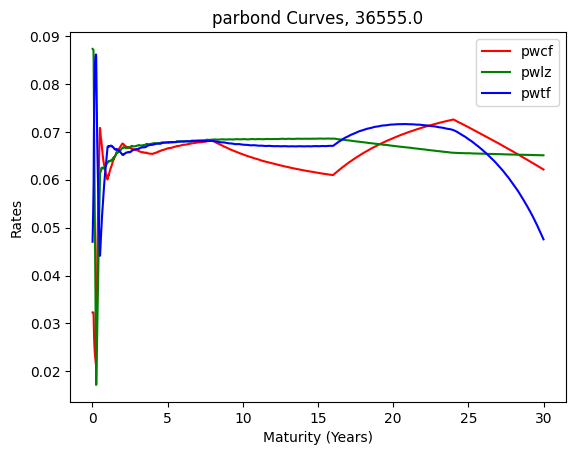

In [190]:
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, 'parbond')

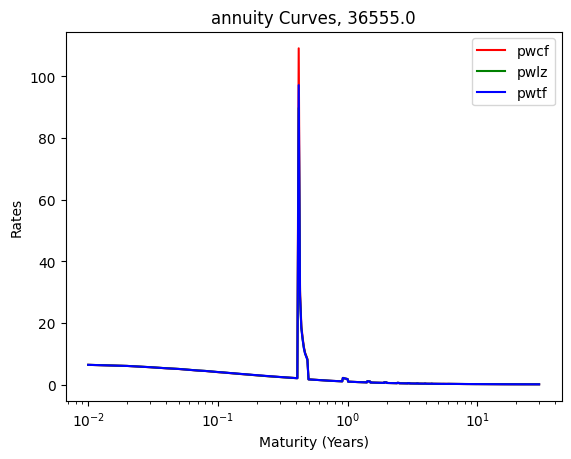

In [191]:
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, 'annuity', log_scale=True)

Connected to Python 3.9.10

In [1]:
import sys
import os
import numpy as np
import numpy_financial
import pandas as pd
import matplotlib.pyplot as plt
import time
import ast
import re
#%%

sys.path.append('../../src/package')
sys.path.append('../../../BondsTable')
sys.path.append('../../tests')
sys.path.append('../../data')
import discfact as df
import pvfn as pv
import DateFunctions_1 as dates
import Curve_Plotting as cp
# OUTPUT_DIR = 'C:/Users/zhang/OneDrive/Documents/GitHub/UST-yieldcurves_2024/curve_utils/output'

OUTPUT_DIR = '../../output'
#%%

def parbond_rates(curve, parbd_breaks_yr, twostep=False, parmflag=True, padj=False):
    """Take in an input curve (breaks, rates) and maturities for calculating par bond rates and prices. """
## this function takes in an input curve (breaks, rates) and maturities for calculating
## par bond rates. It uses the standard 
##   coupon = (100 - PVZero) / PVAnnuity
## which is based on PV(par bond) = 100. 
## This gives the right answer on coupon dates, but because accrued interest is linear
## (rather than exponential) it does not quite give the right answer in between coupons
## Instead, we want to use the definition for a par bond:
##   coupon = yield 
## We can use a two-step procedure to get very close to the answer:
## 1) Calculate the coupon using the PV = 100 formula above
## 2) Calculate the yield for a bond with that coupon
## Because the coupon from step 1 will be within a few bp of the correct answer, 
## the yield for a bond with that coupon (close to the par bond coupon) will now
## be even closer to the par bond coupon. For all practical pursposes this will
## be close enough. (A quick test for 2999 plot points from .01 to 30 by .01, with a curve:
##     quotedate = 31-dec-1932
##     breaks = 1mth, 6mth, 1yr, 2yr, 5yr, 10yr, 20yr, 30yr
##     rates = 2%, 2.5%, 3%, 3.5%, 4%, 4.5%, 5%, 6%
## shows errors of roughly 2bp at the very short end (a few days) and a mean square
## error of 0.28bp. For the second step, errors at the short end are on the order of
## E-10bp, and mse of 0.001bp)
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + parbd_breaks_yr*365.25,0)
    parms_maturity= []
    parms_annuity = []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    parms_annuity = pd.DataFrame(parms_annuity)
    parms_pb = parms_maturity.copy()  # Make a copy which will be for the par bonds
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1]
    accrued_interest = xx[:,1]-xx[:,0]
    # This calculates the coupon rate for a clean price of 100
    # This uses "Price = 100" but this is a good defintion of "par bond" only on an exact coupon date
    # Otherwise, I think we should use "Coupon = Yield"
    # The coupon calculated in this way will almost be the right coupon, but not quite
    # We can do a quick fix by calculating the yield for this coupon, because
    # this will be almost the coupon that makes yield = coupon
    coupon_rates = (100-df_maturity)/(pv_annuity - accrued_interest)
    parms_pb[0] = coupon_rates
    dirtyprice = coupon_rates * pv_annuity + df_maturity
    pbrates = coupon_rates.copy()/100.
    if twostep:
        # Now loop through bonds to calculate yields
        for j in range(len(pbrates)):
            pbrates[j] = pv.bondYieldFromPrice_callable(dirtyprice[j], 
                            parms=parms_pb.loc[j:j], 
                            settledate=xquotedate, parmflag=True, padj=False)
    return pbrates, dirtyprice

def zerobond_rates(curve, zerobd_breaks_yr, parmflag=True, padj=False):
    """Take in an input curve (breaks, rates) and maturities for calculating zero bond rates and prices. """
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + zerobd_breaks_yr*365.25,0)
    parms_maturity= []
    for i in plot_points:   # Make the dummy bonds for zero and annuity
        parms_maturity_single = [0,i,2,100.,"A/A","eomyes",0, False]
        parms_maturity.append(parms_maturity_single)
    parms_maturity = pd.DataFrame(parms_maturity)
    df_maturity = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_maturity)[:,1]
    # Which of the following to use? Shape looks the sames, but different scales
    # zbrates = df_maturity.copy()/100.
    # for j in range(len(zbrates)):
    #     zbrates[j] = pv.bondYieldFromPrice_callable(df_maturity[j], parms=parms_maturity.loc[j:j],
    #                                                  parmflag=True, padj=False)
    discount_curve = df.discFact(plot_points,curve)
    zbrates = np.log(discount_curve)/(-plot_points)
    return zbrates, df_maturity

def annuity_rates(curve, annuity_breaks_yr, parmflag=True, padj=False):
    """Take in an input curve (breaks, rates) and maturities for calculating annuity rates and prices. """
    xquotedate = curve[1]
    plot_points = np.round(xquotedate + annuity_breaks_yr*365.25,0)
    parms_annuity = []
    for i in plot_points:
        parms_annuity_single = [1.,i,2,0.,"A/A","eomyes",0, False]
        parms_annuity.append(parms_annuity_single)
    parms_annuity = pd.DataFrame(parms_annuity)
    xx = pv.pvBondFromCurve(curve, settledate = xquotedate, parms = parms_annuity)
    pv_annuity = xx[:,1] # dirty price
    annuityrates = pv_annuity.copy()/100.
    for j in range(len(annuityrates)):
        annuityrates[j] = pv.bondYieldFromPrice_callable(
            pv_annuity[j], parms=parms_annuity.loc[j:j], parmflag=True, padj=False)
    return annuityrates, pv_annuity
#################################################################################

def produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, rate_type, twostep=False,
                            parmflag=True, padj=False):
    """
    Generate dataframes for par bond, zero bond, or annuity rates and prices from a given yield curve dataframe.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curve information with columns ['type', 'quotedate', 'breaks', 'rates'].
        rate_breaks_yr (list): List of maturities (in years) for which the rates are to be calculated.
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    Returns:
        rates_df (pd.DataFrame): DataFrame containing the calculated rates with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
        prices_df (pd.DataFrame): DataFrame containing the corresponding bond prices with columns ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr].
    Raises:
        ValueError: If rate_type is not one of 'parbond', 'zerobond', or 'annuity'.
    """
    rates = []
    prices = []
    for index, row in curve_df.iterrows():
        curve = [row['type'], row['quotedate'], row['breaks'], row['rates']]
        if rate_type == 'parbond':
            rate, price = parbond_rates(curve, rate_breaks_yr, twostep, parmflag, padj)
        elif rate_type == 'zerobond':
            rate, price = zerobond_rates(curve, rate_breaks_yr, parmflag, padj)
        elif rate_type == 'annuity':
            rate, price = annuity_rates(curve, rate_breaks_yr, parmflag, padj)
        else:
            raise ValueError("rate_type must be one of 'parbond', 'zerobond', or 'annuity'")
        rates.append([curve[0], curve[1]] + list(rate))
        prices.append([curve[0], curve[1]] + list(price))
    columns = ['type', 'quotedate'] + [f'{yr}YR' for yr in rate_breaks_yr]
    rates_df = pd.DataFrame(rates, columns=columns)
    prices_df = pd.DataFrame(prices, columns=columns)
    return rates_df, prices_df
#%% Plot par bond, zero bond, annuity yield curves

def plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type, twostep=False,
                           parmflag=True, padj=False, log_scale=False):
    """
    This function takes in input curves (breaks, rates) and plots par bond curves 
    at a quarterly frequency. It plots 3 types of curves all at once.
    Args:
        curve_df (pd.DataFrame): DataFrame containing the curves data.
        plot_points_yr (list): List of maturities (in years) for which the rates are to be calculated.
        quote_date(float): Quote date, in the form of julian date, e.g., quote_date = 36555.0
        rate_type (str): Type of rate to calculate. Must be one of 'parbond', 'zerobond', or 'annuity'.
        twostep (bool, optional): If True, use a two-step procedure for calculating par bond rates. Defaults to False.
        parmflag (bool, optional): Parameter flag for rate calculations. Defaults to True.
        padj (bool, optional): Adjustment parameter for rate calculations. Defaults to False.
    """
    colors = {'pwcf': 'red', 'pwlz': 'green', 'pwtf': 'blue'}
    curve_df_qd = curve_df.loc[curve_df['quotedate'] == quote_date]
    rate_df, price_df = produce_pb_zb_anty_dfs(curve_df_qd, plot_points_yr, rate_type, twostep, parmflag, padj)
    # sqrt root in the short-term
    # def transform_x(x): 
    #     """ Transform x-axis values to expand the scale for values below 4 years. """
    #     if x < 4:
    #         return x * 2
    #     else:
    #         return 4 + (x - 4)
    # plot_points_yr = np.array([transform_x(x) for x in plot_points_yr])
    for curvetype, color in colors.items():
        curve_row = rate_df[rate_df['type'] == curvetype]
        if curve_row.empty:
            continue
        rates = curve_row.iloc[0, 2:].values
        plt.plot(plot_points_yr, rates, color=color, label=curvetype)
    plt.legend()
    plt.title(f'{rate_type} Curves, {quote_date}')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Rates')
    if log_scale == True:
        plt.xscale('log')
    # plt.savefig(f"../../output/{rate_type}_curves_{quote_date}.png")
    plt.show()

c:\Users\zhang\OneDrive\Documents\GitHub\UST-yieldcurves_2024\curve_utils\src\package\../development\crsp_data_processing.py:46: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  bonddata = pd.read_csv(filepath)
c:\Users\zhang\OneDrive\Documents\GitHub\UST-yieldcurves_2024\curve_utils\src\package\../development\crsp_data_processing.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bonddata['Spread'] = bonddata['TMASK'] - bonddata['TMBID']
c:\Users\zhang\OneDrive\Documents\GitHub\UST-yieldcurves_2024\curve_utils\src\package\../development\crsp_data_processing.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [2]:
outfile = 'test2000'
curve_df = pd.read_pickle(OUTPUT_DIR+'/'+outfile+'_curve.pkl')

In [3]:
curve_df

type  quotedate  \
type_ind quotedate_ind                    
pwcf     20000131       pwcf  [36555.0]   
         20000229       pwcf  [36584.0]   
pwlz     20000131       pwlz  [36555.0]   
         20000229       pwlz  [36584.0]   
pwtf     20000131       pwtf  [36555.0]   
         20000229       pwtf  [36584.0]   

                                                                   breaks  \
type_ind quotedate_ind                                                      
pwcf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwlz     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   
pwtf     20000131       [36582.980835044524, 36646.93702943191, 36738....   
         20000229       [36610.980835044524, 36674.93702943191, 36766....   

                                                                    rates  
type_ind quotedate_ind                                                     
pwcf     20000131       [0.03155834861641242, 0.01624840911648632, 0.1...  
         20000229       [0.04333817646520892, 0.06865186999190424, 0.0...  
pwlz     20000131       [0.08306564790634006, 0.016131279869252384, 0....  
         20000229       [0.10923360890959918, -0.0016923185531181129, ...  
pwtf     20000131       [0.055888072351500756, 0.095167363313876, 0.00...  
         20000229       [0.01800434919547239, 0.12044565495031759, -0....

In [4]:
plot_points_yr = np.arange(.01,30,.01)

In [5]:
plot_points_yr

array([1.000e-02, 2.000e-02, 3.000e-02, ..., 2.997e+01, 2.998e+01,
       2.999e+01])

In [6]:
outfile = 'test2000'
curve_df = pd.read_pickle(OUTPUT_DIR+'/'+outfile+'_curve.pkl')
plot_points_yr = np.arange(.01,30,.01)
rate_breaks_yr = np.array([0.0833, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20])

In [7]:
parbd_rates_df, parbd_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'parbond',
                                                          twostep=True, parmflag=True, padj=False)

In [8]:
parbd_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],0.030762,0.071055,0.059919,0.064970,0.067514,0.066100,0.065391,0.066509,0.067777,0.065314,0.061452,0.068704
1,pwcf,[36584.0],0.046416,0.059464,0.063735,0.064943,0.065544,0.066511,0.066992,0.066847,0.066682,0.066056,0.065302,0.064805
2,pwlz,[36555.0],0.082613,0.061094,0.063380,0.065033,0.066641,0.067125,0.067579,0.067794,0.068198,0.068455,0.068580,0.067087
3,pwlz,[36584.0],0.106748,0.064613,0.064126,0.064048,0.063972,0.065966,0.067912,0.067160,0.065630,0.064685,0.064304,0.066415
4,pwtf,[36555.0],0.060297,0.044257,0.066682,0.066416,0.065140,0.066372,0.067273,0.067709,0.068041,0.067300,0.066982,0.071502
5,pwtf,[36584.0],0.029164,0.041333,0.067820,0.065234,0.062848,0.066573,0.068378,0.065971,0.063701,0.068082,0.072090,0.067734


In [9]:
parbd_prices_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],101.288412,103.521677,100.016495,103.225965,100.0,100.000000,100.0,100.018278,100.000000,100.0,100.000000,100.0
1,pwcf,[36584.0],101.950468,100.000000,100.000000,100.000000,100.0,103.305477,100.0,100.000000,103.315228,100.0,103.247095,100.0
2,pwlz,[36555.0],103.498335,103.027973,100.017448,103.229064,100.0,100.000000,100.0,100.018631,100.000000,100.0,100.000000,100.0
3,pwlz,[36584.0],104.543910,100.000000,100.000000,100.000000,100.0,103.278381,100.0,100.000000,103.262935,100.0,103.197482,100.0
4,pwtf,[36555.0],102.541198,102.193478,100.018357,103.297760,100.0,100.000000,100.0,100.018607,100.000000,100.0,100.000000,100.0
5,pwtf,[36584.0],101.221083,100.000000,100.000000,100.000000,100.0,103.308552,100.0,100.000000,103.167025,100.0,103.584662,100.0


In [10]:
zerobd_rates_df, zerobd_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'zerobond',
                                                            parmflag=True, padj=False)

annuity_rates_df, annuity_prices_df = produce_pb_zb_anty_dfs(curve_df, rate_breaks_yr, 'annuity',
                                                              parmflag=True, padj=False)

In [11]:
zerobd_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],6.853698e-08,9.523142e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000016,0.000021,0.000033
1,pwcf,[36584.0],1.029346e-07,7.985115e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000029
2,pwlz,[36555.0],1.817431e-07,8.206623e-07,0.000002,0.000003,0.000004,0.000005,0.000007,0.000009,0.000012,0.000017,0.000024,0.000030
3,pwlz,[36584.0],2.332949e-07,8.665677e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000022,0.000030
4,pwtf,[36555.0],1.333690e-07,5.969880e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000009,0.000012,0.000016,0.000023,0.000034
5,pwtf,[36584.0],6.495138e-08,5.575007e-07,0.000002,0.000003,0.000003,0.000005,0.000007,0.000008,0.000011,0.000017,0.000026,0.000030


In [12]:
annuity_rates_df

,type,quotedate,0.0833YR,0.5YR,1.0YR,1.5YR,2.0YR,3.0YR,4.0YR,5.0YR,7.0YR,10.0YR,15.0YR,20.0YR
0,pwcf,[36555.0],4.344500,1.690187,1.792394,0.665001,0.694820,0.440326,0.327363,0.264192,0.195824,0.147121,0.109716,0.093387
1,pwcf,[36584.0],3.304015,4.637202,1.538979,0.915885,0.654895,0.349913,0.318895,0.258690,0.175668,0.145184,0.104144,0.093205
2,pwlz,[36555.0],4.377953,1.683928,1.790086,0.664771,0.694161,0.440378,0.328039,0.264992,0.196447,0.148040,0.112649,0.095952
3,pwlz,[36584.0],3.327262,4.659276,1.542068,0.916466,0.654583,0.349602,0.318825,0.258764,0.175535,0.144546,0.103477,0.092944
4,pwtf,[36555.0],4.363618,1.672856,1.783982,0.664180,0.693013,0.439536,0.327467,0.264622,0.196227,0.147661,0.111807,0.096295
5,pwtf,[36584.0],3.297278,4.560088,1.533802,0.914218,0.653042,0.349283,0.318767,0.258503,0.174896,0.144502,0.106036,0.096263


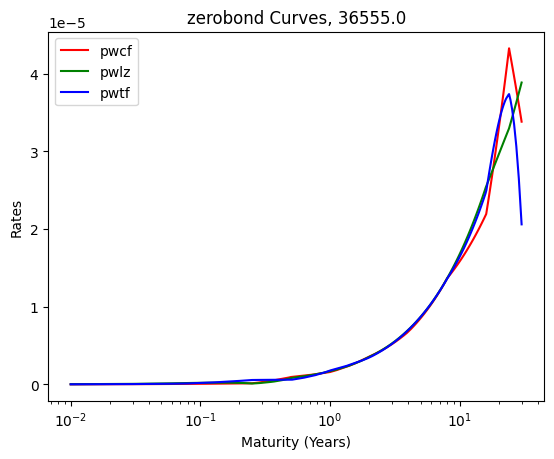

In [13]:
quote_date = 36555.0
rate_type = 'zerobond'
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type, log_scale=True)

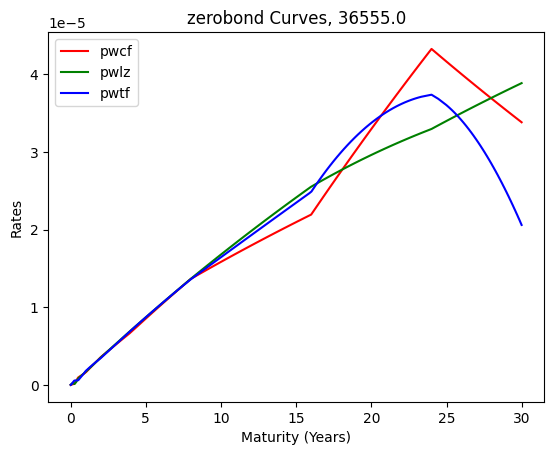

In [14]:
plot_pb_zb_anty_curve(curve_df, plot_points_yr, quote_date, rate_type, log_scale=False)

In [15]:
df_price_yield = pd.read_pickle(OUTPUT_DIR+'/'+outfile+'_predyld.pkl')

In [16]:
df_price_yield

type  QuoteDate   MatYr  MatMth  MatDay   Coup  \
type QuoteDate                                                   
pwcf 20000131   pwcf   20000131  2000.0     2.0     3.0  0.000   
     20000131   pwcf   20000131  2000.0     2.0    10.0  0.000   
     20000131   pwcf   20000131  2000.0     2.0    15.0  5.875   
     20000131   pwcf   20000131  2000.0     2.0    15.0  8.500   
     20000131   pwcf   20000131  2000.0     2.0    17.0  0.000   
...              ...        ...     ...     ...     ...    ...   
pwtf 20000229   pwtf   20000229  2028.0     8.0    15.0  5.500   
     20000229   pwtf   20000229  2028.0    11.0    15.0  5.250   
     20000229   pwtf   20000229  2029.0     2.0    15.0  5.250   
     20000229   pwtf   20000229  2029.0     8.0    15.0  6.125   
     20000229   pwtf   20000229  2030.0     5.0    15.0  6.250   

                predictedprice  actualprice  predictedyield  actualyield  
type QuoteDate                                                            
pwcf 20000131        99.974083    99.958167        0.031809     0.051597  
     20000131        99.913635    99.861111        0.031809     0.051414  
     20000131       102.804176   100.007812        0.031809     0.842502  
     20000131       104.114976   100.105469        0.031809     1.277422  
     20000131        99.853224    99.760588        0.031809     0.052169  
...                        ...          ...             ...          ...  
pwtf 20000229        97.024001    89.414062        0.057285     0.063227  
     20000229        95.395212    86.257812        0.056849     0.064203  
     20000229        94.423579    86.351562        0.056579     0.062955  
     20000229       106.664579    98.371094        0.056736     0.062646  
     20000229       111.063166   101.500000        0.056107     0.062730  

[1254 rows x 10 columns]

In [17]:
import DateFunctions_1 as dates
dates.JuliantoYMD(36555)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [18]:
import DateFunctions_1 as dates
dates.JuliantoYMD(np.array(36555))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.